# Insights and Actionable Items
## 1 - Insights by Product and Region
### 1.1 - Trends by Price and Product ✅
- Gasolina and Diesel has moderate linear trend.✅
- Etanol presents a greater variability and is more dependent on season factors (e.g., sugarcane).✅
### 1.2 - Seasonality by Product✅
- Etanol and Gasolina presents clear season patterns, increasing in the middle of the year (jun/jul).✅
- Diesel does not present seasonality, what may indicate that it does not deppend much in short-term factors.✅
###  1.3 - Monthly volatility
- Etanol is the  most volatile, specially in Centro-Oeste and Sudeste.
- Diesel has a low volatility, what suggests a greater previsibility.
### 1.4 - Regional Difference
- Expensive prices at Nordeste for all fuels (logistic + limited competition).
- Cheaper prices at Centro-Oeste para Etanol (local production).

## 2 - Price's elasticity by Label
The Elasticity says how the demand changes when the price changes.

Elasticity = \delta(demand)/\delta(price).

To calculate that, we will use the number of stations (proxy supply/demand) and the price variation by label, region and product.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats.mstats import winsorize
import numpy as np
from scipy.stats import linregress
import geopandas as gpd
import matplotlib.patches as mpatches

In [2]:
data = pd.read_parquet("./../data/02_silver/oil_and_gas_dataset-candidate-features.parquet")
data

,bandeira_revenda_cat,sigla_uf,id_municipio,produto,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data,winsor_preco_compra,log_n_estabelecimentos,faixa_estabelecimentos,month,monthly_volatility,price_spread,rolling_avg_venda_3m,rolling_std_venda_3m
0,White Label,PE,2603405,Diesel,1,1.107405,1.300000,2004-05-01,1.235000,0.693147,1–3,2004-05-01,0.079858,0.192595,1.314232,0.020128
1,Green Label,PE,2613909,Etanol,4,0.877773,1.316875,2004-05-01,0.877773,1.609438,4–10,2004-05-01,0.266893,0.439102,1.203313,0.160602
2,White Label,PE,2606408,Etanol,4,0.912080,1.171667,2004-05-01,0.912080,1.609438,4–10,2004-05-01,0.266893,0.259587,1.192764,0.115023
3,Blue Label,PE,2616407,Gasolina,2,1.713060,1.910000,2004-05-01,1.760000,1.098612,1–3,2004-05-01,0.138337,0.196940,1.970263,0.085225
4,White Label,PE,2613008,Diesel,4,1.222909,1.342500,2004-05-01,1.235000,1.609438,4–10,2004-05-01,0.079858,0.119591,1.323655,0.021654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556493,Purple Label,SP,3530706,Etanol,1,3.516582,4.040000,2024-08-01,3.516582,0.693147,1–3,2024-08-01,0.433357,0.523418,4.576667,0.530126
556494,Purple Label,SP,3513009,Gasolina,3,5.201834,5.956667,2024-08-01,5.201834,1.386294,1–3,2024-08-01,0.300885,0.754833,6.212222,0.267360
556495,White Label,MG,3119401,Diesel,5,5.120835,5.864545,2024-08-01,5.120835,1.791759,4–10,2024-08-01,0.315130,0.743710,6.131515,0.231689
556496,Blue Label,GO,5205109,Etanol,3,3.490204,4.010000,2024-08-01,3.490204,1.386294,1–3,2024-08-01,0.433357,0.519796,4.383333,0.620833


### Monthly Volatility

- Volatility is calculated using the standard deviation of prices within each group.
- The `.std()` function returns the dispersion of values — the higher it is, the more unstable the price is for that month/location.


In [3]:
import pandas as pd

# Garante que a coluna 'month' esteja em datetime mensal
data['month'] = pd.to_datetime(data['month']).dt.to_period('M').dt.to_timestamp()

# --- Mapeia sigla_uf para região ---
uf_to_region = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

data['regiao'] = data['sigla_uf'].map(uf_to_region)

# --- Volatilidade mensal por UF ---
vol_uf = (
    data.groupby(['month', 'sigla_uf', 'produto'])['avg_preco_venda']
    .std()
    .reset_index()
    .rename(columns={'avg_preco_venda': 'volatilidade_mensal'})
)

# --- Volatilidade mensal por Região ---
vol_regiao = (
    data.groupby(['month', 'regiao', 'produto'])['avg_preco_venda']
    .std()
    .reset_index()
    .rename(columns={'avg_preco_venda': 'volatilidade_mensal'})
)

# --- Concatena e adiciona coluna 'nível' ---
tabela_volatilidade = pd.concat([
    vol_uf.assign(nivel='UF'),
    vol_regiao.assign(nivel='Região')
])

# Preenche a coluna 'regiao' apenas onde o nível for UF
tabela_volatilidade.loc[tabela_volatilidade['nivel'] == 'UF', 'regiao'] = (
    tabela_volatilidade.loc[tabela_volatilidade['nivel'] == 'UF', 'sigla_uf'].map(uf_to_region)
)

# Exibe a tabela
display(tabela_volatilidade)


,month,sigla_uf,produto,volatilidade_mensal,nivel,regiao
0,2004-05-01,AC,Diesel,0.085085,UF,Norte
1,2004-05-01,AC,Etanol,0.141033,UF,Norte
2,2004-05-01,AC,Gasolina,0.144259,UF,Norte
3,2004-05-01,AL,Diesel,0.020492,UF,Nordeste
4,2004-05-01,AL,Etanol,0.086150,UF,Nordeste
...,...,...,...,...,...,...
2050,2024-08-01,NaN,Etanol,0.306199,Região,Sudeste
2051,2024-08-01,NaN,Gasolina,0.249595,Região,Sudeste
2052,2024-08-01,NaN,Diesel,0.239789,Região,Sul
2053,2024-08-01,NaN,Etanol,0.433041,Região,Sul


### 1. Line Chart: Volatility Trends by Region and Product

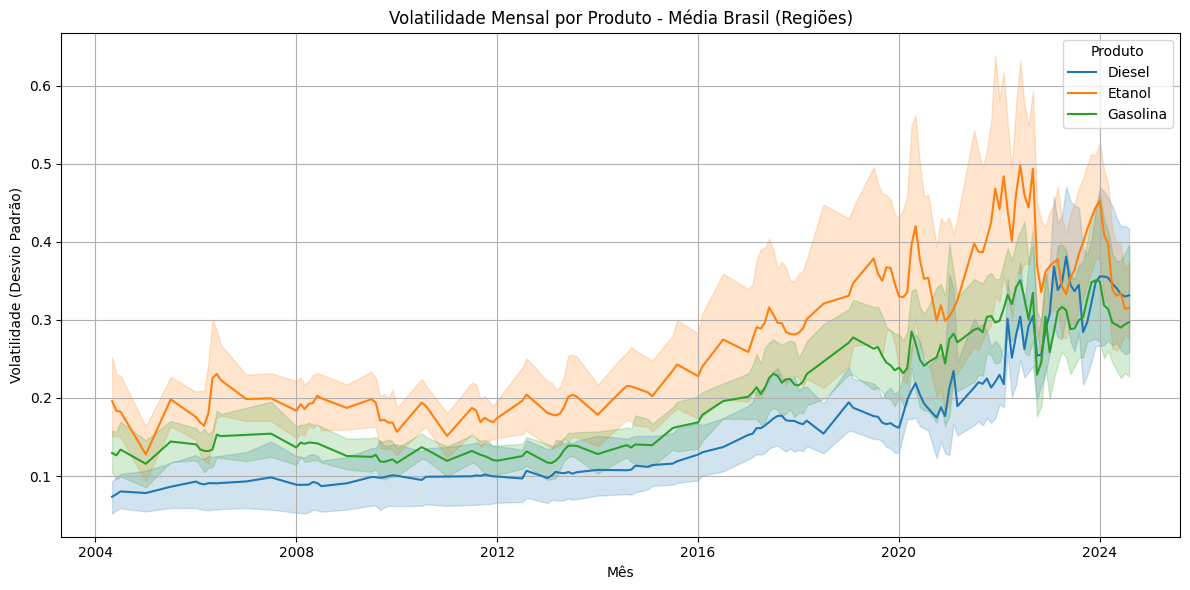

In [4]:
# Filtra apenas nível Região
regiao_df = tabela_volatilidade[tabela_volatilidade['nivel'] == 'Região']

plt.figure(figsize=(12, 6))
sns.lineplot(data=regiao_df, x='month', y='volatilidade_mensal', hue='produto')
plt.title("Volatilidade Mensal por Produto - Média Brasil (Regiões)")
plt.xlabel("Mês")
plt.ylabel("Volatilidade (Desvio Padrão)")
plt.grid(True)
plt.tight_layout()
plt.legend(title='Produto')
plt.show()


### 2. Heatmap Chart: Volatility by State (UF) and Product Over Time

In [5]:
def plot_volatilidade_heatmap_produto_regiao(tabela_volatilidade, produto, regiao):
    """
    Plota um mapa de calor da volatilidade mensal por UF dentro de uma região para um produto específico.
    """

    # Filtro
    df_filtro = tabela_volatilidade[
        (tabela_volatilidade['produto'] == produto) &
        (tabela_volatilidade['nivel'] == 'UF') &
        (tabela_volatilidade['regiao'] == regiao)
    ]

    if df_filtro.empty:
        print(f"Nenhum dado encontrado para {produto} na região {regiao}.")
        return

    # Pivot
    heatmap_df = df_filtro.pivot(index="sigla_uf", columns="month", values="volatilidade_mensal")

    # Plot
    plt.figure(figsize=(18, 6))
    ax = sns.heatmap(
        heatmap_df,
        cmap="YlOrRd",
        linewidths=0.3,
        linecolor='lightgray',
        cbar_kws={'label': 'Monthly Volatility'}
    )

    plt.title(f"Monthly Volatility – {produto} | Região: {regiao}", fontsize=14, fontweight='bold')
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("UF", fontsize=12)

    # Formatação de datas no eixo X
    xticks = ax.get_xticks()
    xticklabels = heatmap_df.columns.to_list()
    formatted_labels = [x.strftime("%Y-%m") for x in xticklabels]

    if len(formatted_labels) > 12:
        # Exibe rótulos de ano em ano
        ax.set_xticks(range(0, len(formatted_labels), 12))
        ax.set_xticklabels(formatted_labels[::12], rotation=45, ha='right', fontsize=8)
    else:
        ax.set_xticks(range(len(formatted_labels)))
        ax.set_xticklabels(formatted_labels, rotation=45, ha='right', fontsize=8)

    ax.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.savefig(f"volatilidade_{produto}_{regiao}.png")
    plt.show()


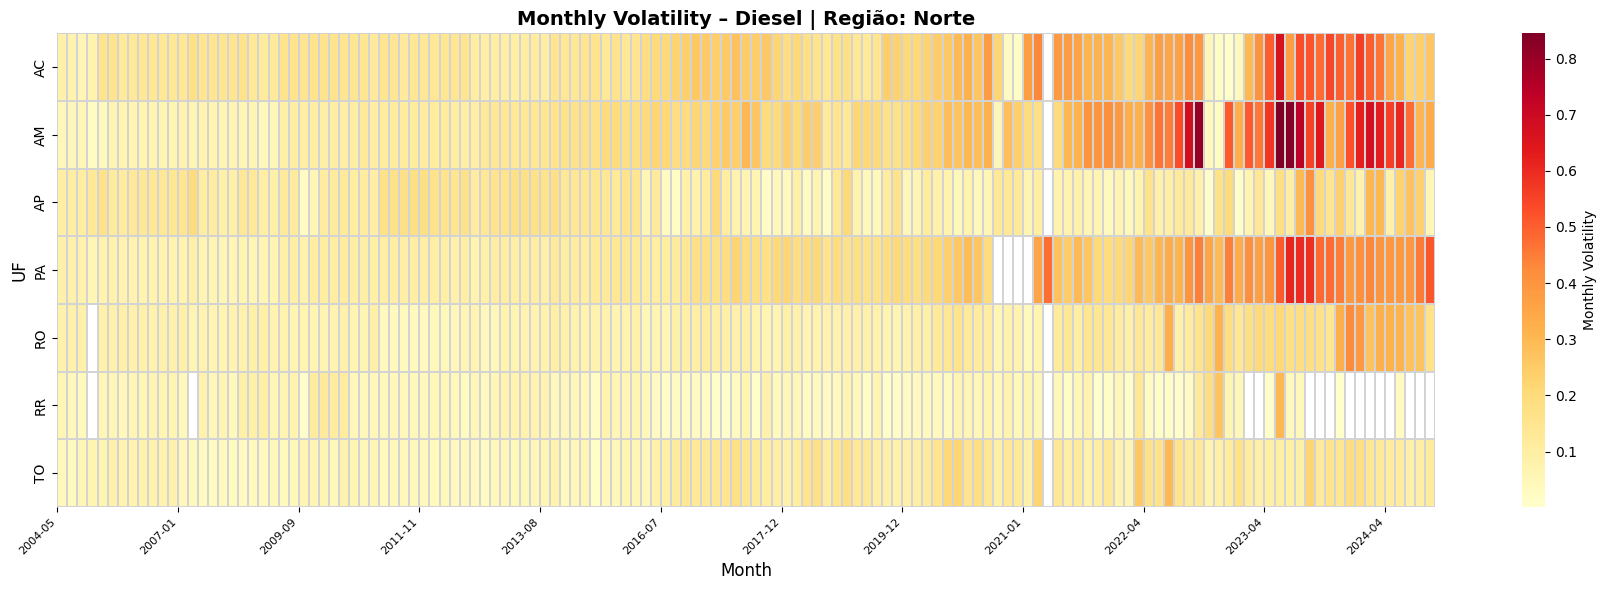

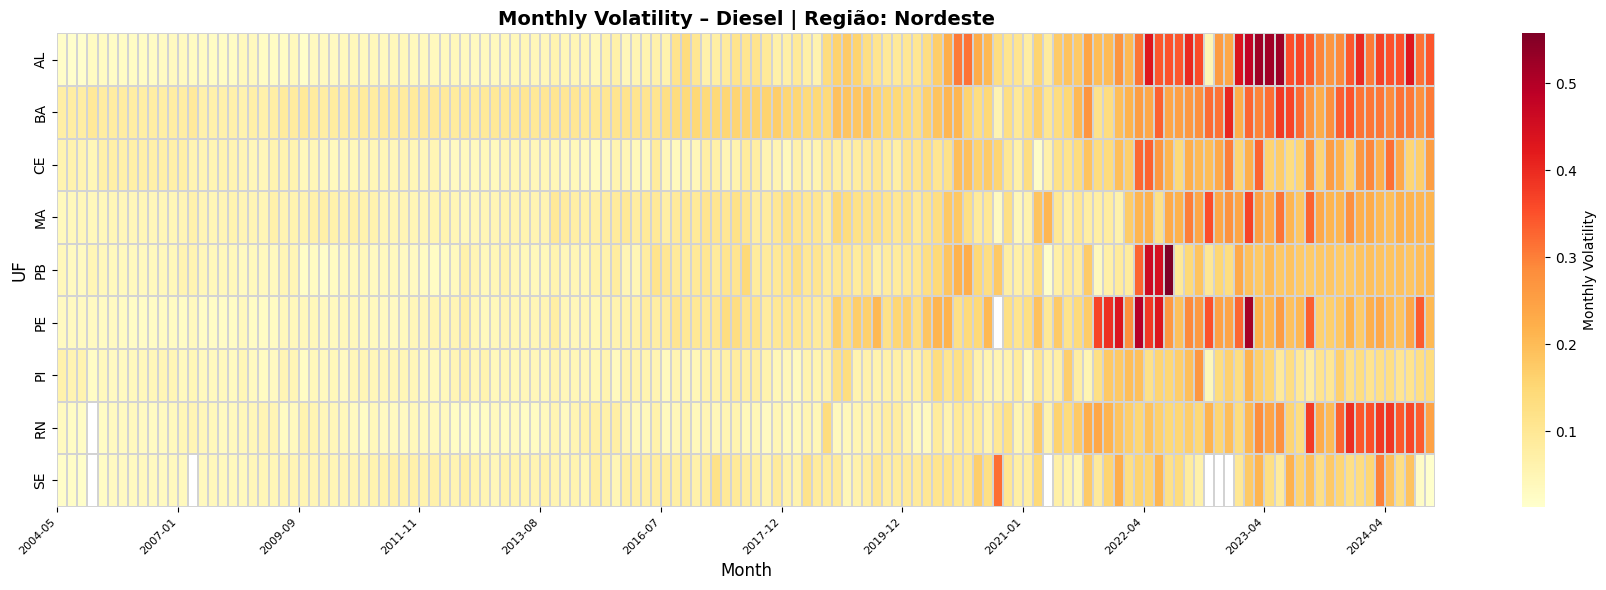

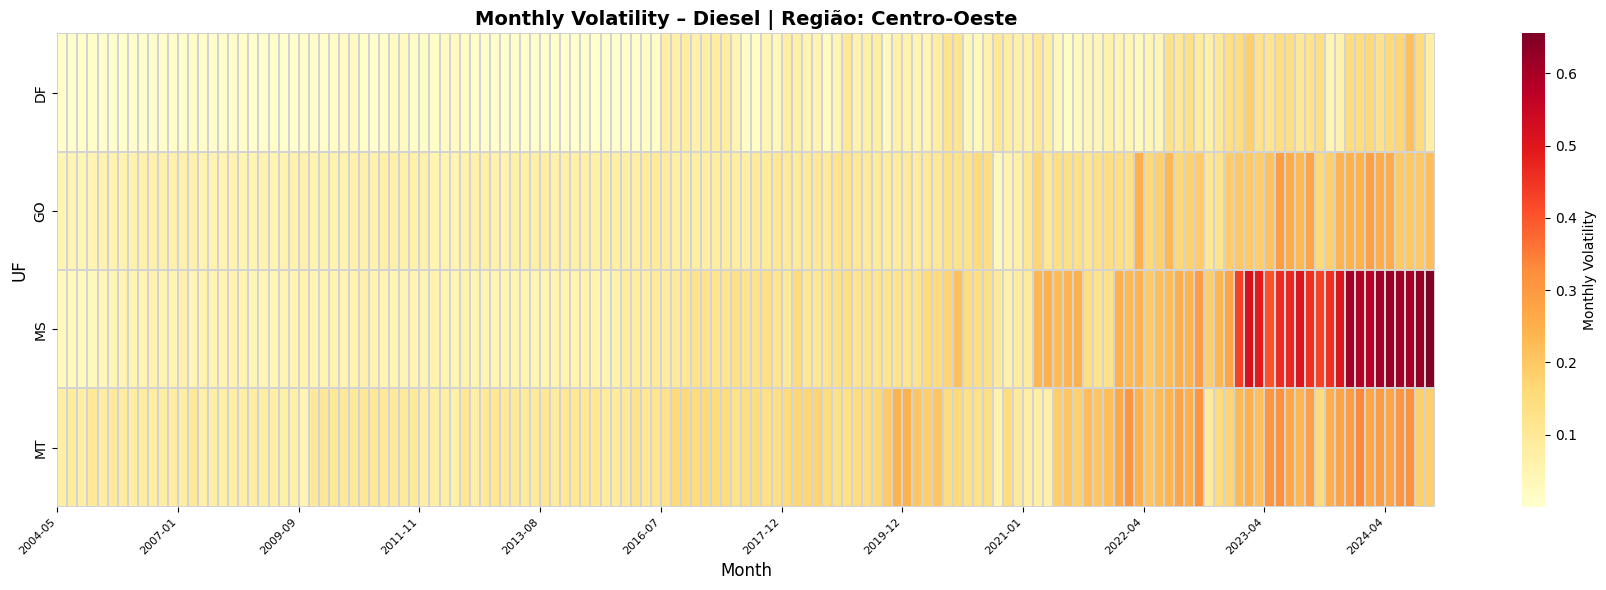

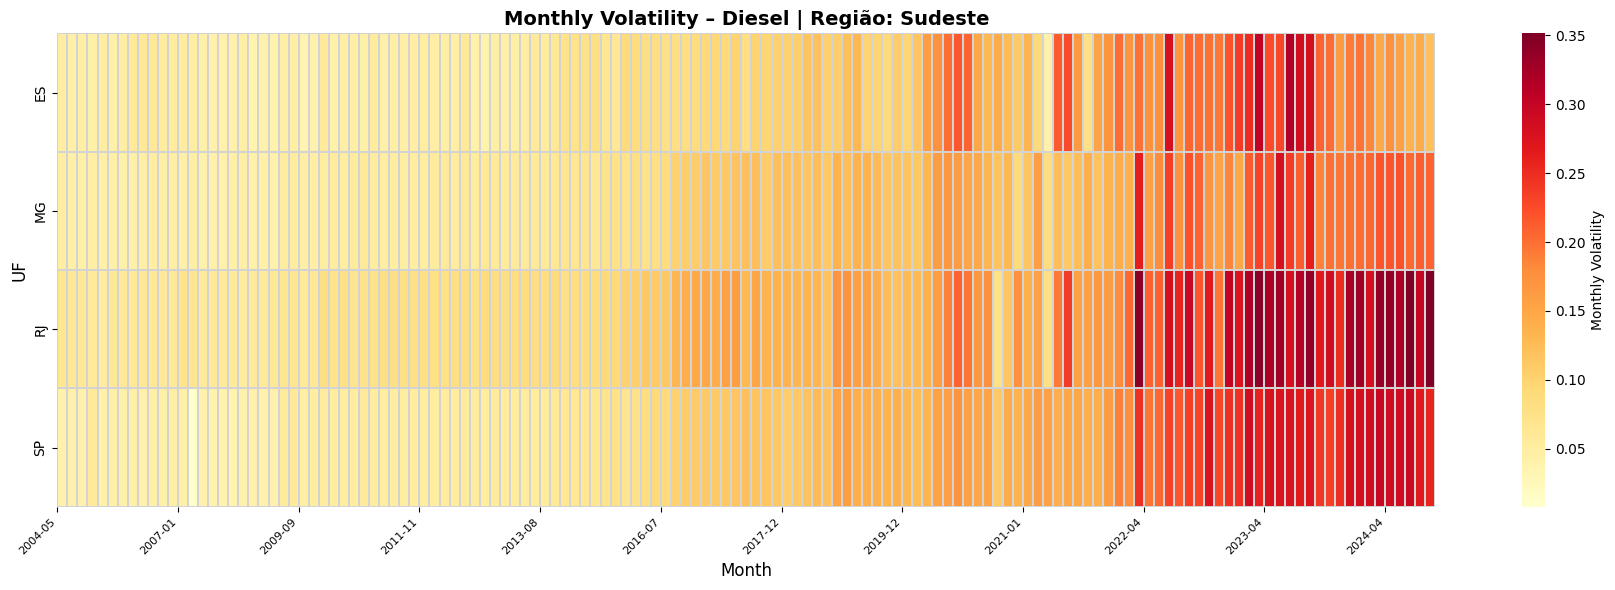

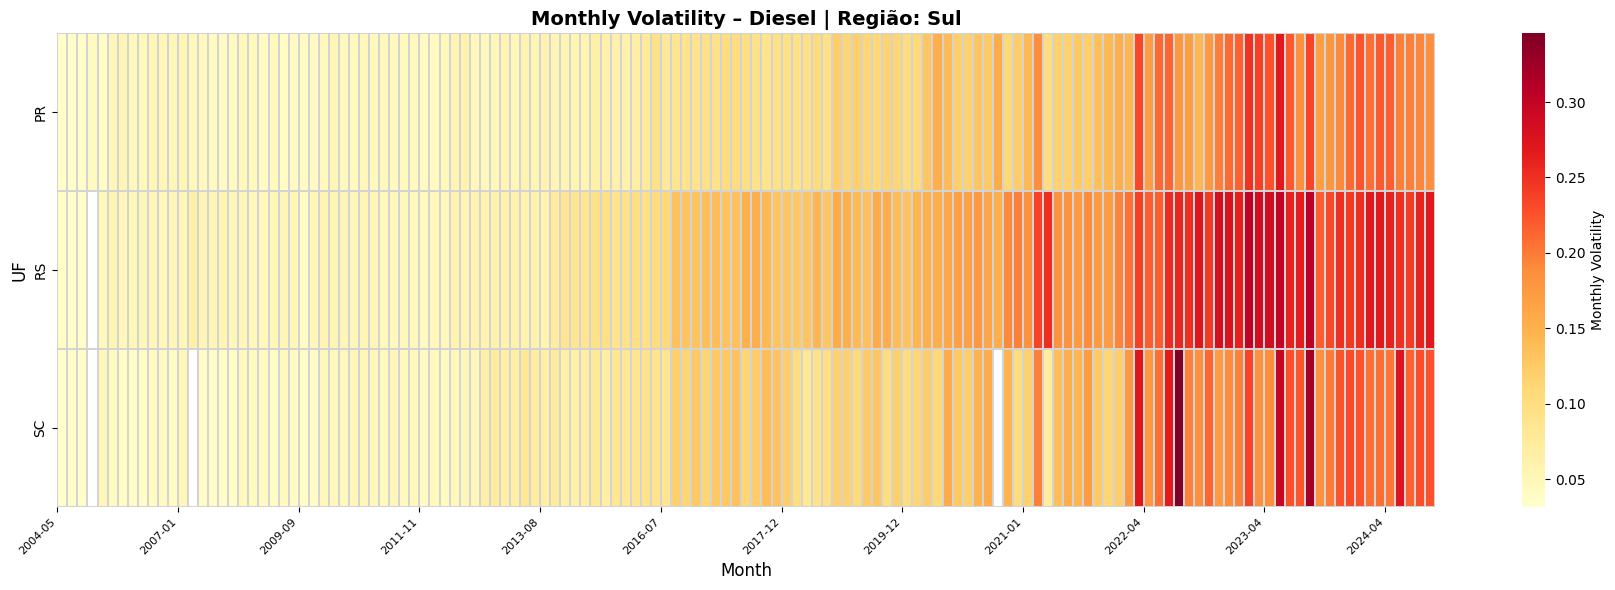

In [6]:
for regiao in tabela_volatilidade.regiao.unique():
    #for produto in tabela_volatilidade.produto.unique():
    produto = "Diesel"
    plot_volatilidade_heatmap_produto_regiao(tabela_volatilidade, produto, regiao)

## 🔍 Conclusions Based on Volatility

### 1. Products with Higher Volatility
Historically, ethanol tends to show greater volatility compared to diesel and gasoline.

This may be related to:

- Dependency on sugarcane harvests (climate factors)
- Direct competition with gasoline (substitutability)
- Greater sensitivity to blending policy (anhydrous vs. hydrated)

### 2. Regions with High Volatility
Some states and regions show noticeable volatility peaks, such as:

- RJ and AC with high ethanol fluctuations in recent years
- North and Northeast regions tend to oscillate more — possibly due to logistics challenges, fewer resellers, or local regulatory instability

### 3. Relative Stability of Diesel
Diesel generally presents lower volatility, due to:

- Constant high demand (freight transport)
- Stricter regulation at certain periods
- Lower sensitivity to end consumer behavior

### 4. Seasonal Patterns
Some states show seasonal volatility:

- Recurring peaks during the same months
- This may indicate opportunity windows or require planning alerts (e.g., stocking up before instability periods)

---

## 🛠️ What to Do With This Information?

| Insight | Recommended Action |
|--------|--------------------|
| High volatility of a product in a region | Avoid aggressive price increases, as consumers may be price-sensitive. Consider dynamic adjustment clauses in contracts. |
| Rising volatility in a specific state | Investigate local causes (e.g., tax changes, unreliable suppliers). May require supply chain review. |
| Stability in diesel and gasoline | Enables more conservative pricing policies. Opportunity to build loyalty through cashback or rewards programs. |
| Predictable seasonal volatility | Plan purchases and inventory ahead of time. Implement dynamic pricing (e.g., increase prices before demand peaks). |
| Very high ethanol volatility | Consider more robust predictive models (e.g., include climate and agricultural factors). Evaluate price pass-through carefully. |
| Regional differences | Adopt geolocated pricing strategies. Avoid a single national policy if volatility differs significantly across regions. |


### Code to Calculate Price Elasticity of Demand

We don't have actual sales volume data to calculate elasticity.

**Practical assumption**: We'll assume each station sells a constant average quantity per month and use:
$$volume\_vendas = n\_estabelecimentos \times average\_factor$$


In [7]:
# --- Parâmetros ---
fator_litros_por_posto = 100_000  # Fator estimado de litros vendidos por posto
winsor_limits = [0.01, 0.01]      # 1% em cada extremo

# --- Garante que a coluna 'month' esteja em datetime ---
data['month'] = pd.to_datetime(data['month'])

# --- Aplica winsorization em avg_preco_venda ---
data['winsor_preco_venda'] = winsorize(data['avg_preco_venda'], limits=winsor_limits)

# --- Calcula volume de vendas estimado ---
data['volume_vendas'] = (
    data['n_estabelecimentos'] * fator_litros_por_posto *
    (1 - data['monthly_volatility'].fillna(0))
)

# --- Agregação mensal por região e produto ---
agg = (
    data.groupby(['regiao', 'produto', 'month'])
    .agg({
        'winsor_preco_venda': 'mean',
        'volume_vendas': 'sum'
    })
    .reset_index()
)

# --- Ordena os dados por mês ---
agg = agg.sort_values(['regiao', 'produto', 'month'])

# --- Calcula as variações mensais ---
agg['var_preco'] = agg.groupby(['regiao', 'produto'])['winsor_preco_venda'].pct_change()
agg['var_volume'] = agg.groupby(['regiao', 'produto'])['volume_vendas'].pct_change()

# --- Calcula elasticidade ---
agg['elasticidade'] = agg['var_volume'] / agg['var_preco']

# --- Filtra valores extremos para interpretação mais estável ---
agg['elasticidade_cortada'] = agg['elasticidade'].clip(lower=-10, upper=10)

# --- Elasticidade média por região/produto ---
elasticidade_media = (
    agg.groupby(['regiao', 'produto'])['elasticidade_cortada']
    .mean()
    .reset_index()
    .sort_values('elasticidade_cortada')
)

# Exibe resultado
display(elasticidade_media)


,regiao,produto,elasticidade_cortada
2,Centro-Oeste,Gasolina,-0.484484
4,Nordeste,Etanol,-0.089055
7,Norte,Etanol,-0.068555
14,Sul,Gasolina,0.027465
10,Sudeste,Etanol,0.347793
1,Centro-Oeste,Etanol,0.389375
8,Norte,Gasolina,0.420201
11,Sudeste,Gasolina,0.556210
6,Norte,Diesel,0.681535
9,Sudeste,Diesel,0.759544


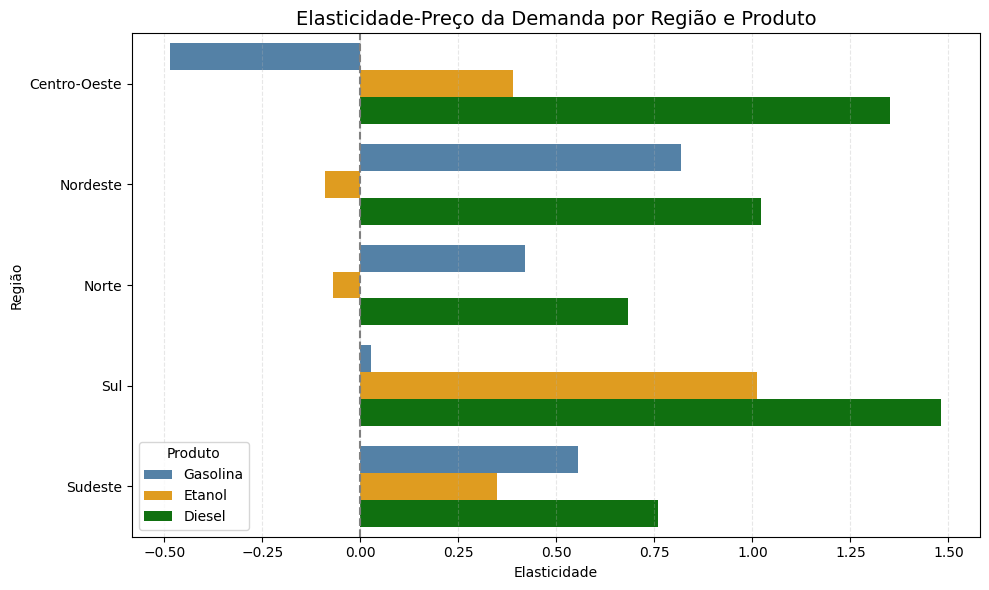

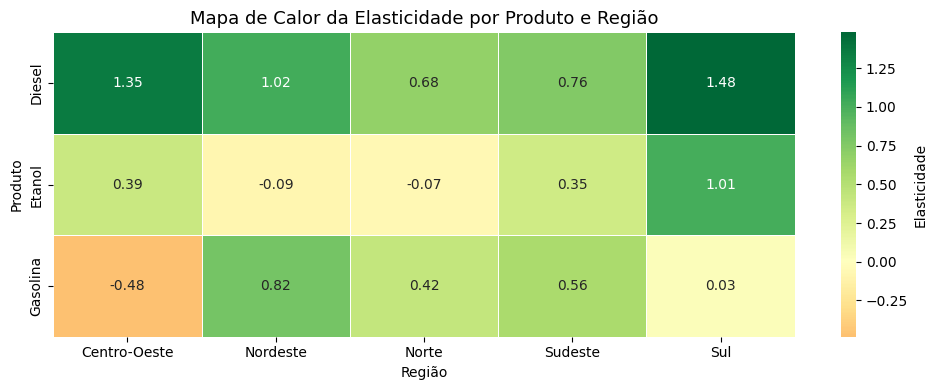

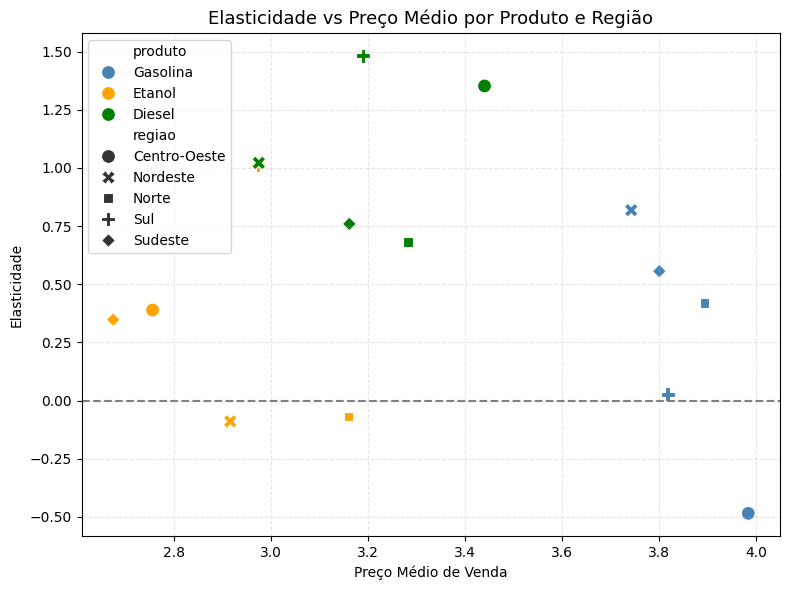

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define a paleta de cores por produto
paleta = {
    'Gasolina': 'steelblue',
    'Etanol': 'orange',
    'Diesel': 'green'
}

# --- 1. Gráfico de Barras por Região e Produto ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=elasticidade_media,
    x='elasticidade_cortada',
    y='regiao',
    hue='produto',
    palette=paleta
)
plt.title("Elasticidade-Preço da Demanda por Região e Produto", fontsize=14)
plt.xlabel("Elasticidade")
plt.ylabel("Região")
plt.axvline(0, color='gray', linestyle='--')
plt.legend(title='Produto')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. Mapa de Calor (Produto x Região) ---
heatmap_data = elasticidade_media.pivot(index='produto', columns='regiao', values='elasticidade_cortada')

plt.figure(figsize=(10, 4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Elasticidade"}
)
plt.title("Mapa de Calor da Elasticidade por Produto e Região", fontsize=13)
plt.xlabel("Região")
plt.ylabel("Produto")
plt.tight_layout()
plt.show()

# --- 3. Dispersão: Elasticidade vs Preço Médio ---
# Junta com preço médio se quiser usar essa comparação
precos_medios = data.groupby(['regiao', 'produto'])['avg_preco_venda'].mean().reset_index()
merged = pd.merge(elasticidade_media, precos_medios, on=['regiao', 'produto'])

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged,
    x='avg_preco_venda',
    y='elasticidade_cortada',
    hue='produto',
    style='regiao',
    palette=paleta,
    s=100
)
plt.title("Elasticidade vs Preço Médio por Produto e Região", fontsize=13)
plt.xlabel("Preço Médio de Venda")
plt.ylabel("Elasticidade")
plt.axhline(0, linestyle='--', color='gray')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Basic Interpretation

- **Positive elasticity** values suggest that volume increases with price — which may indicate an anomalous behavior or a substitution effect.
- **Negative elasticity** values suggest that customers easily abandon the product — typical of price-sensitive markets.
- **Elasticity values near 0** indicate inelastic demand (little variation with price), which opens room for price increases without significant loss in volume.

---

**1. Apparent Substitutability or Indirect Substitution Effect**

Imagine gasoline prices increased less than ethanol prices. In that case, consumers may switch back to gasoline, increasing its demand even at a higher price.

This occurs because consumption decisions are driven by relative prices, and a simple regional regression model doesn't capture cross-product effects.

---

**2. Anomalous Behavior or Signs of Distortion**

This may indicate issues such as:

- Unmodeled product substitution (e.g., ethanol vs. gasoline)
- Measurement errors in estimated volume
- Low prices being perceived as poor product quality, leading consumers to avoid it
- Local promotions or regional policy incentives


In [9]:
# Classificação por faixas
def classificar_faixa(elast):
    if elast > 1:
        return "Alta Elasticidade"
    elif elast > 0.2:
        return "Elasticidade Moderada"
    else:
        return "Baixa Elasticidade (Inelástico)"

# Aplica classificação
elasticidade_media['faixa_elasticidade'] = elasticidade_media['elasticidade_cortada'].apply(classificar_faixa)

# Visualiza
display(elasticidade_media.sort_values('elasticidade_cortada', ascending=False))


,regiao,produto,elasticidade_cortada,faixa_elasticidade
12,Sul,Diesel,1.482187,Alta Elasticidade
0,Centro-Oeste,Diesel,1.352239,Alta Elasticidade
3,Nordeste,Diesel,1.021655,Alta Elasticidade
13,Sul,Etanol,1.012088,Alta Elasticidade
5,Nordeste,Gasolina,0.818363,Elasticidade Moderada
9,Sudeste,Diesel,0.759544,Elasticidade Moderada
6,Norte,Diesel,0.681535,Elasticidade Moderada
11,Sudeste,Gasolina,0.556210,Elasticidade Moderada
8,Norte,Gasolina,0.420201,Elasticidade Moderada
1,Centro-Oeste,Etanol,0.389375,Elasticidade Moderada


### ✅ 2. Strategic Map by Product

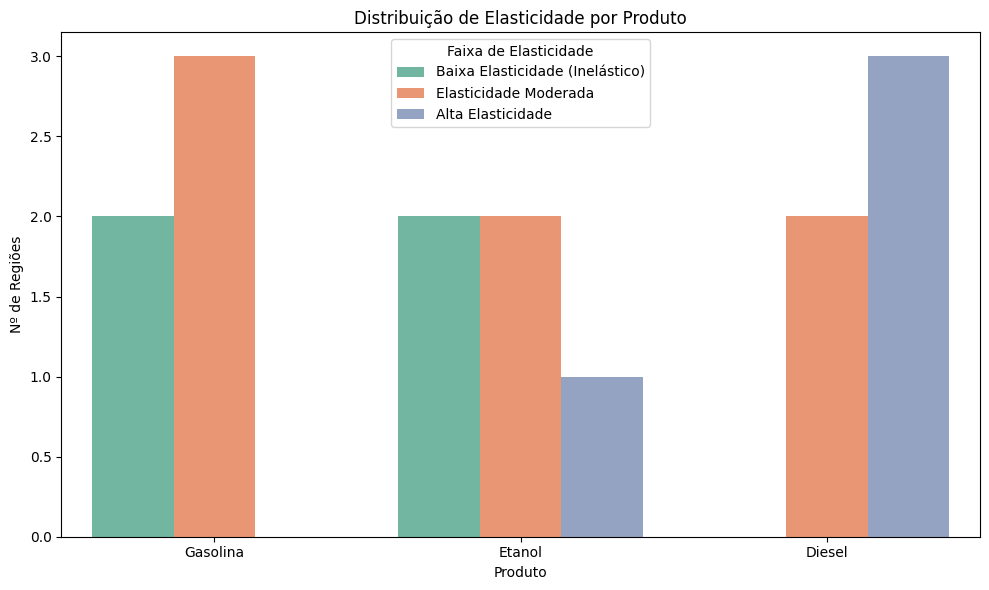

In [10]:
# Gráfico por produto
plt.figure(figsize=(10, 6))
sns.countplot(data=elasticidade_media, x="produto", hue="faixa_elasticidade", palette="Set2")
plt.title("Distribuição de Elasticidade por Produto")
plt.ylabel("Nº de Regiões")
plt.xlabel("Produto")
plt.legend(title="Faixa de Elasticidade")
plt.tight_layout()
plt.show()


### ✅ 3. Strategic Action Table by Region and Product

In [11]:
# Geração da ação sugerida
def acao_estrategica(faixa):
    if faixa == "Baixa Elasticidade (Inelástico)":
        return "🟢 Considerar aumento de preço"
    elif faixa == "Elasticidade Moderada":
        return "🟡 Avaliar aumento com cautela"
    else:
        return "🔴 Evitar aumento – risco de perda de demanda"

elasticidade_media["acao_recomendada"] = elasticidade_media["faixa_elasticidade"].apply(acao_estrategica)

# Visualiza
display(
    elasticidade_media[["regiao", "produto", "elasticidade_cortada", "faixa_elasticidade", "acao_recomendada"]]
    .sort_values(by="elasticidade_cortada", ascending=False)
)


,regiao,produto,elasticidade_cortada,faixa_elasticidade,acao_recomendada
12,Sul,Diesel,1.482187,Alta Elasticidade,🔴 Evitar aumento – risco de perda de demanda
0,Centro-Oeste,Diesel,1.352239,Alta Elasticidade,🔴 Evitar aumento – risco de perda de demanda
3,Nordeste,Diesel,1.021655,Alta Elasticidade,🔴 Evitar aumento – risco de perda de demanda
13,Sul,Etanol,1.012088,Alta Elasticidade,🔴 Evitar aumento – risco de perda de demanda
5,Nordeste,Gasolina,0.818363,Elasticidade Moderada,🟡 Avaliar aumento com cautela
9,Sudeste,Diesel,0.759544,Elasticidade Moderada,🟡 Avaliar aumento com cautela
6,Norte,Diesel,0.681535,Elasticidade Moderada,🟡 Avaliar aumento com cautela
11,Sudeste,Gasolina,0.556210,Elasticidade Moderada,🟡 Avaliar aumento com cautela
8,Norte,Gasolina,0.420201,Elasticidade Moderada,🟡 Avaliar aumento com cautela
1,Centro-Oeste,Etanol,0.389375,Elasticidade Moderada,🟡 Avaliar aumento com cautela


### Elasticity by State

In [12]:
# Garante formato de data
data['month'] = pd.to_datetime(data['month'])

# Agrupamento por UF, produto e mês
agg_uf = (
    data.groupby(['sigla_uf', 'produto', 'month'])
    .agg({
        'winsor_preco_venda': 'mean',
        'volume_vendas': 'sum'
    })
    .reset_index()
    .sort_values(['sigla_uf', 'produto', 'month'])
)

# Variações percentuais mês a mês
agg_uf['pct_delta_preco'] = agg_uf.groupby(['sigla_uf', 'produto'])['winsor_preco_venda'].pct_change()
agg_uf['pct_delta_volume'] = agg_uf.groupby(['sigla_uf', 'produto'])['volume_vendas'].pct_change()

# Elasticidade-preço
agg_uf['elasticidade'] = agg_uf['pct_delta_volume'] / agg_uf['pct_delta_preco']

# Remove valores extremos ou inválidos
agg_uf = agg_uf.replace([np.inf, -np.inf], np.nan).dropna(subset=['elasticidade'])

# Elasticidade média por UF (agregada entre produtos ou separada)
elasticidade_uf = (
    agg_uf.groupby('sigla_uf')['elasticidade']
    .mean()
    #.clip(lower=-50, upper=50)
    .reset_index()
)

# Visualização opcional
print(elasticidade_uf.sort_values('elasticidade'))


   sigla_uf  elasticidade
18       RJ -6.625590e+11
17       PR -5.013541e+11
14       PB -6.142097e+02
4        BA -5.179890e+01
9        MA -2.980001e+01
20       RO -2.601784e+01
11       MS -1.212553e+01
15       PE -7.703003e+00
3        AP -5.332158e+00
12       MT -4.028060e+00
26       TO -2.318273e+00
19       RN -1.829835e+00
2        AM  1.394721e+00
24       SE  1.924802e+00
21       RR  6.391322e+00
7        ES  8.526970e+00
16       PI  1.378383e+01
25       SP  1.857784e+01
6        DF  1.890491e+01
0        AC  3.196703e+01
1        AL  3.293814e+01
13       PA  3.472199e+01
5        CE  3.731821e+01
10       MG  8.218701e+01
23       SC  9.583543e+01
22       RS  7.239794e+02
8        GO  1.774913e+12


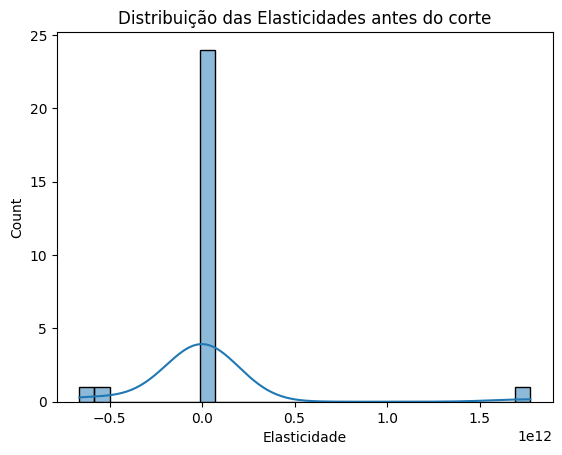

In [13]:
sns.histplot(elasticidade_uf['elasticidade'], bins=30, kde=True)
plt.title("Distribuição das Elasticidades antes do corte")
plt.xlabel("Elasticidade")
plt.show()


In [14]:
# 1. Cálculo do IQR para avg_preco_compra
Q1 = data['avg_preco_compra'].quantile(0.25)
Q3 = data['avg_preco_compra'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# 2. Filtra os dados sem outliers
data_iqr = data[(data['avg_preco_compra'] >= limite_inferior) & (data['avg_preco_compra'] <= limite_superior)].copy()

# 3. Volume de vendas estimado (ajustável)
fator_litros_por_posto = 100_000
data_iqr['volume_vendas'] = (
    data_iqr['n_estabelecimentos'] * fator_litros_por_posto *
    (1 - data_iqr['monthly_volatility'].fillna(0))
)

# 4. Calcula a elasticidade-preço da demanda por UF
elasticidade_por_uf = (
    data_iqr.groupby('sigla_uf')
    .apply(lambda df: linregress(np.log(df['avg_preco_compra']), np.log(df['volume_vendas'])).slope)
    .reset_index(name='elasticidade_iqr')
)

# 5. Visualiza os resultados
elasticidade_por_uf = elasticidade_por_uf.sort_values(by='elasticidade_iqr')
display(elasticidade_por_uf)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\4138936958.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: linregress(np.log(df['avg_preco_compra']), np.log(df['volume_vendas'])).slope)


,sigla_uf,elasticidade_iqr
6,DF,-1.293729
11,MS,-0.765858
23,SC,-0.573309
14,PB,-0.524427
22,RS,-0.480180
10,MG,-0.428601
17,PR,-0.422135
25,SP,-0.392369
7,ES,-0.381984
18,RJ,-0.350388


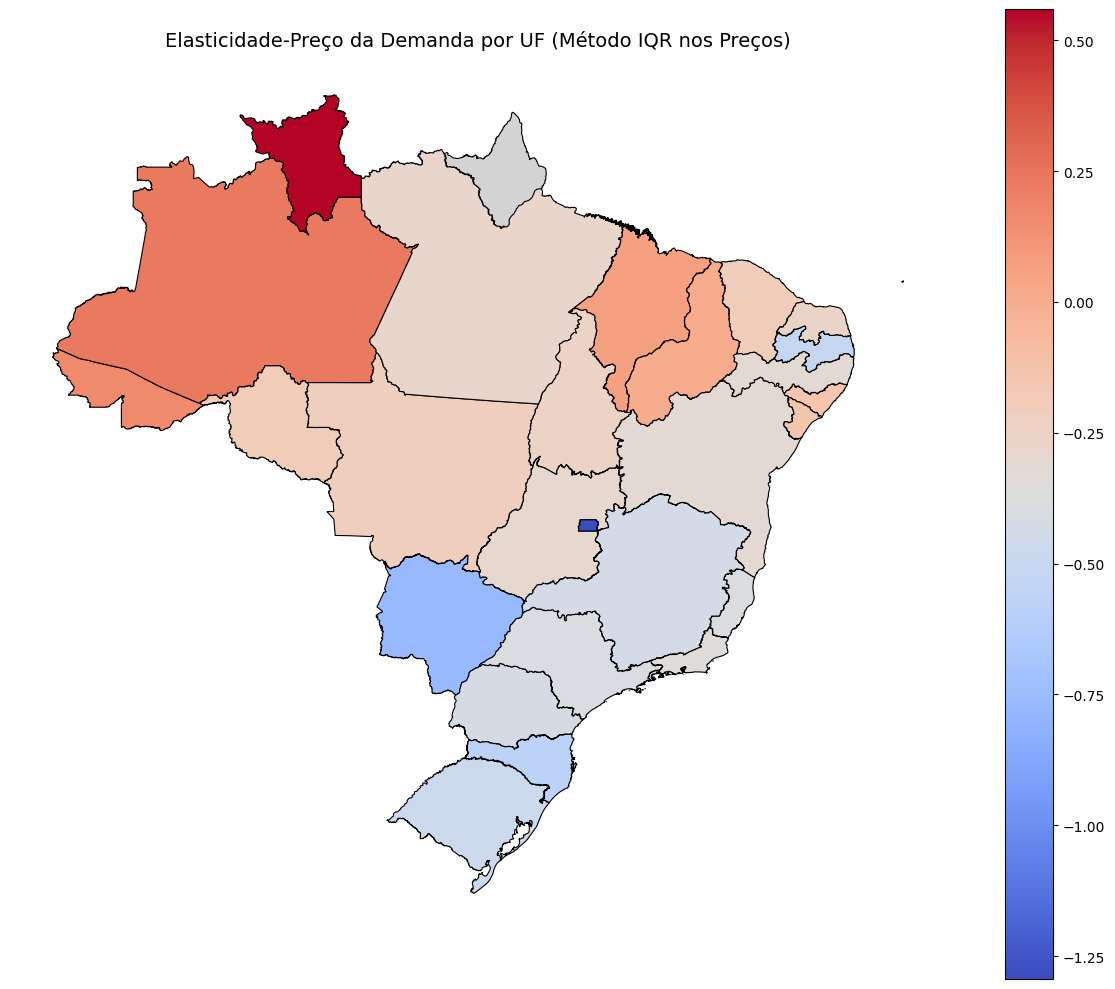

,sigla_uf,elasticidade_iqr
6,DF,-1.293729
11,MS,-0.765858
23,SC,-0.573309
14,PB,-0.524427
22,RS,-0.480180
10,MG,-0.428601
17,PR,-0.422135
25,SP,-0.392369
7,ES,-0.381984
18,RJ,-0.350388


In [15]:
# 1. Garante datetime
data['month'] = pd.to_datetime(data['month'])

# 2. Aplica IQR nos preços de compra
Q1 = data['avg_preco_compra'].quantile(0.25)
Q3 = data['avg_preco_compra'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

data_iqr = data[(data['avg_preco_compra'] >= limite_inferior) & (data['avg_preco_compra'] <= limite_superior)].copy()

# 3. Volume de vendas estimado
fator_litros_por_posto = 100_000
data_iqr['volume_vendas'] = (
    data_iqr['n_estabelecimentos'].astype(float).fillna(0) * fator_litros_por_posto *
    (1 - data_iqr['monthly_volatility'].astype(float).fillna(0))
)

# 4. Calcula elasticidade por UF usando log-log com linregress
elasticidades = []
for uf, grupo in data_iqr.groupby('sigla_uf'):
    x = np.log(grupo['avg_preco_compra'].astype(float).replace(0, np.nan).dropna())
    y = np.log(grupo.loc[x.index, 'volume_vendas'].replace(0, np.nan).dropna())
    if len(x) > 1 and len(y) > 1:
        slope, _, _, _, _ = linregress(x, y)
        elasticidades.append({'sigla_uf': uf, 'elasticidade_iqr': slope})

elasticidade_iqr_df = pd.DataFrame(elasticidades)

# 5. Carrega shapefile do Brasil
br_gdf = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')
estado_para_sigla = {
    'Acre': 'AC', 'Alagoas': 'AL', 'Amazonas': 'AM', 'Bahia': 'BA', 'Ceará': 'CE',
    'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO', 'Maranhão': 'MA',
    'Minas Gerais': 'MG', 'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Pará': 'PA',
    'Paraíba': 'PB', 'Pernambuco': 'PE', 'Piauí': 'PI', 'Paraná': 'PR', 'Rio de Janeiro': 'RJ',
    'Rio Grande do Norte': 'RN', 'Rondônia': 'RO', 'Roraima': 'RR', 'Rio Grande do Sul': 'RS',
    'Santa Catarina': 'SC', 'Sergipe': 'SE', 'São Paulo': 'SP', 'Tocantins': 'TO'
}
br_gdf['sigla_uf'] = br_gdf['name'].map(estado_para_sigla)

# 6. Junta com elasticidades
br_gdf = br_gdf.merge(elasticidade_iqr_df, on='sigla_uf', how='left')

# 7. Plota o mapa
fig, ax = plt.subplots(figsize=(12, 10))
br_gdf.plot(
    column='elasticidade_iqr',
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Sem dados suficientes"
    }
)
ax.set_title("Elasticidade-Preço da Demanda por UF (Método IQR nos Preços)", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

# 8. Exibe a tabela final ordenada
display(elasticidade_iqr_df.sort_values("elasticidade_iqr"))


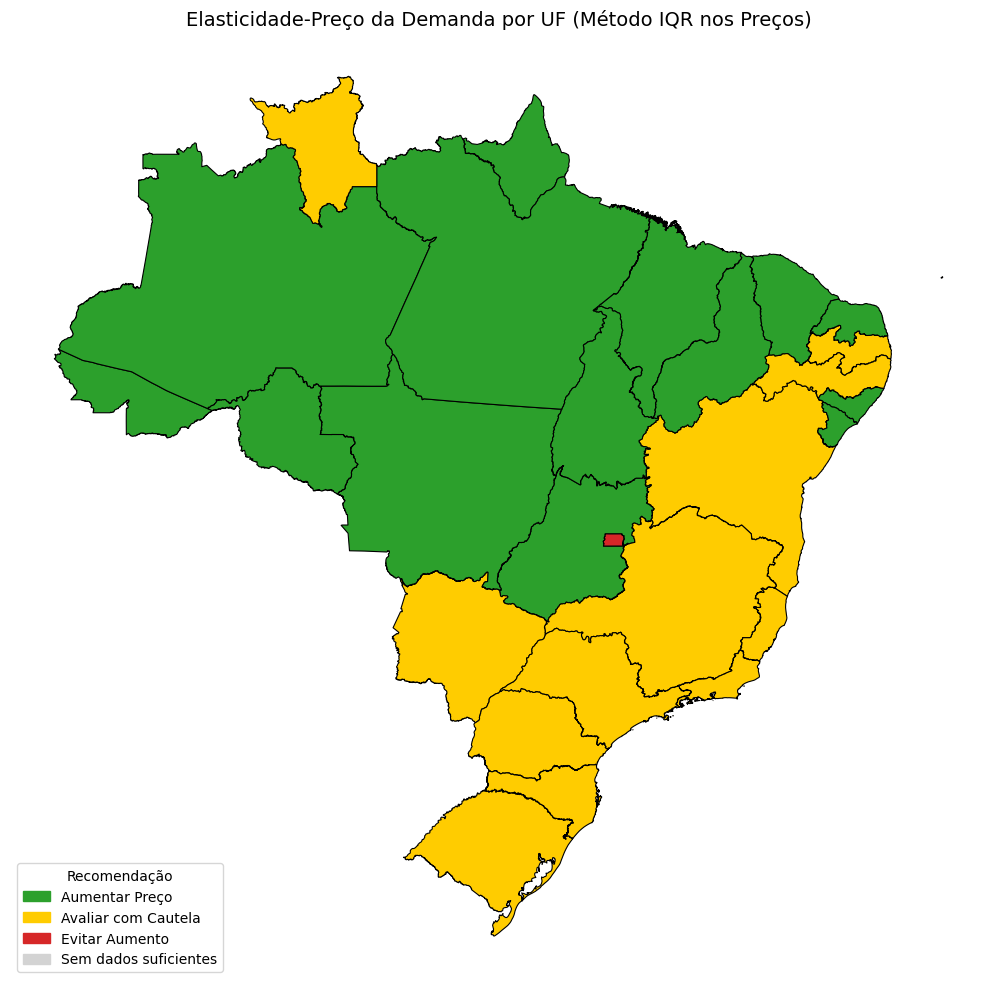

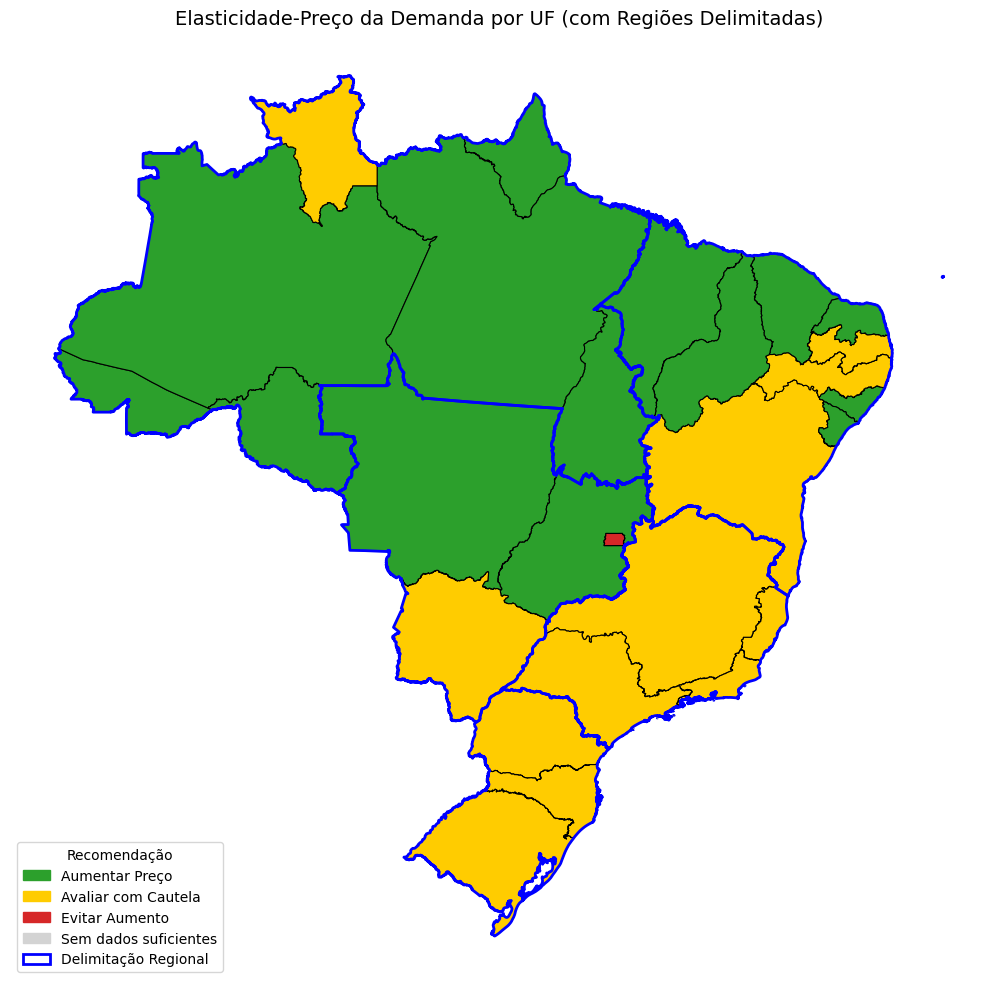

In [16]:
# Recomendação
def classificar_faixa(elast):
    if abs(elast) >= 1:
        return 'Alta Elasticidade'
    elif abs(elast) >= 0.3:
        return 'Elasticidade Moderada'
    else:
        return 'Baixa Elasticidade (Inelástico)'

def recomendar_acao(faixa):
    if faixa == 'Alta Elasticidade':
        return 'Evitar aumento – risco de perda de demanda'
    elif faixa == 'Elasticidade Moderada':
        return 'Avaliar aumento com cautela'
    else:
        return 'Considerar aumento de preço'
    
elasticidade_iqr_df['faixa_elasticidade'] = elasticidade_iqr_df['elasticidade_iqr'].apply(classificar_faixa)
elasticidade_iqr_df['recomendacao'] = elasticidade_iqr_df['faixa_elasticidade'].apply(recomendar_acao)

# Carrega shapefile
br_gdf = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')
estado_para_sigla = {
    'Acre': 'AC', 'Alagoas': 'AL', 'Amazonas': 'AM', 'Amapá': 'AP', 'Bahia': 'BA', 'Ceará': 'CE',
    'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO', 'Maranhão': 'MA',
    'Minas Gerais': 'MG', 'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Pará': 'PA',
    'Paraíba': 'PB', 'Pernambuco': 'PE', 'Piauí': 'PI', 'Paraná': 'PR', 'Rio de Janeiro': 'RJ',
    'Rio Grande do Norte': 'RN', 'Rondônia': 'RO', 'Roraima': 'RR', 'Rio Grande do Sul': 'RS',
    'Santa Catarina': 'SC', 'Sergipe': 'SE', 'São Paulo': 'SP', 'Tocantins': 'TO'
}
br_gdf['sigla_uf'] = br_gdf['name'].map(estado_para_sigla)
br_gdf = br_gdf.merge(elasticidade_iqr_df, on='sigla_uf', how='left')

# Cores
color_map = {
    "Considerar aumento de preço": "#2ca02c",
    "Avaliar aumento com cautela": "#ffcc00",
    "Evitar aumento – risco de perda de demanda": "#d62728",
    "Sem dados suficientes": "lightgrey"
}
br_gdf['cor'] = br_gdf['recomendacao'].map(color_map)

# Mapa
fig, ax = plt.subplots(figsize=(12, 10))

br_gdf.plot(
    color=br_gdf['cor'],
    edgecolor='black',
    linewidth=0.8,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Sem dados suficientes"
    }
)

legendas = [
    mpatches.Patch(color=color_map["Considerar aumento de preço"], label="Aumentar Preço"),
    mpatches.Patch(color=color_map["Avaliar aumento com cautela"], label="Avaliar com Cautela"),
    mpatches.Patch(color=color_map["Evitar aumento – risco de perda de demanda"], label="Evitar Aumento"),
    mpatches.Patch(color="lightgrey", label="Sem dados suficientes")
]

ax.legend(handles=legendas, loc='lower left', title="Recomendação")
ax.set_title("Elasticidade-Preço da Demanda por UF (Método IQR nos Preços)", fontsize=14)
ax.axis('off')
plt.tight_layout()

# Define as regiões manualmente
regioes = {
    "Norte": ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    "Nordeste": ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    "Centro-Oeste": ['DF', 'GO', 'MT', 'MS'],
    "Sudeste": ['ES', 'MG', 'RJ', 'SP'],
    "Sul": ['PR', 'RS', 'SC']
}

# Adiciona coluna de região ao GeoDataFrame
def get_regiao(sigla):
    for regiao, ufs in regioes.items():
        if sigla in ufs:
            return regiao
    return None

br_gdf['regiao'] = br_gdf['sigla_uf'].apply(get_regiao)

# Agrupa por região para traçar as fronteiras
gdf_regioes = br_gdf.dissolve(by='regiao')

# Cores por recomendação
color_map = {
    "Considerar aumento de preço": "#2ca02c",
    "Avaliar aumento com cautela": "#ffcc00",
    "Evitar aumento – risco de perda de demanda": "#d62728",
}
br_gdf['cor'] = br_gdf['recomendacao'].map(color_map).fillna("lightgrey")

# Plotagem do mapa
fig, ax = plt.subplots(figsize=(12, 10))

br_gdf.plot(
    color=br_gdf['cor'],
    edgecolor='black',
    linewidth=0.8,
    ax=ax
)

# Adiciona contornos das regiões
gdf_regioes.boundary.plot(ax=ax, color='blue', linewidth=2)

# Legenda
legendas = [
    mpatches.Patch(color=color_map["Considerar aumento de preço"], label="Aumentar Preço"),
    mpatches.Patch(color=color_map["Avaliar aumento com cautela"], label="Avaliar com Cautela"),
    mpatches.Patch(color=color_map["Evitar aumento – risco de perda de demanda"], label="Evitar Aumento"),
    mpatches.Patch(color="lightgrey", label="Sem dados suficientes"),
    mpatches.Patch(edgecolor='blue', facecolor='none', label="Delimitação Regional", linewidth=2)
]

ax.legend(handles=legendas, loc='lower left', title="Recomendação")
ax.set_title("Elasticidade-Preço da Demanda por UF (com Regiões Delimitadas)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()



In [17]:
def recomendation_by_product(produto):
    # 1. Garante datetime
    df = data[data["produto"] == produto]
    df['month'] = pd.to_datetime(df['month'])

    # 2. Aplica IQR nos preços de compra
    Q1 = df['avg_preco_compra'].quantile(0.25)
    Q3 = df['avg_preco_compra'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df_iqr = df[(df['avg_preco_compra'] >= limite_inferior) & (df['avg_preco_compra'] <= limite_superior)].copy()

    # 3. Volume de vendas estimado
    fator_litros_por_posto = 100_000
    df_iqr['volume_vendas'] = (
        df_iqr['n_estabelecimentos'].astype(float).fillna(0) * fator_litros_por_posto *
        (1 - df_iqr['monthly_volatility'].astype(float).fillna(0))
    )

    # 4. Calcula elasticidade por UF usando log-log com linregress
    elasticidades = []
    for uf, grupo in df_iqr.groupby('sigla_uf'):
        x = np.log(grupo['avg_preco_compra'].astype(float).replace(0, np.nan).dropna())
        y = np.log(grupo.loc[x.index, 'volume_vendas'].replace(0, np.nan).dropna())
        if len(x) > 1 and len(y) > 1:
            slope, _, _, _, _ = linregress(x, y)
            elasticidades.append({'sigla_uf': uf, 'elasticidade_iqr': slope})

    elasticidade_iqr_df = pd.DataFrame(elasticidades)

    # 5. Carrega shapefile do Brasil
    br_gdf = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')
    estado_para_sigla = {
        'Acre': 'AC', 'Alagoas': 'AL', 'Amazonas': 'AM', 'Bahia': 'BA', 'Ceará': 'CE',
        'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO', 'Maranhão': 'MA',
        'Minas Gerais': 'MG', 'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Pará': 'PA',
        'Paraíba': 'PB', 'Pernambuco': 'PE', 'Piauí': 'PI', 'Paraná': 'PR', 'Rio de Janeiro': 'RJ',
        'Rio Grande do Norte': 'RN', 'Rondônia': 'RO', 'Roraima': 'RR', 'Rio Grande do Sul': 'RS',
        'Santa Catarina': 'SC', 'Sergipe': 'SE', 'São Paulo': 'SP', 'Tocantins': 'TO'
    }
    br_gdf['sigla_uf'] = br_gdf['name'].map(estado_para_sigla)

    # 6. Junta com elasticidades
    br_gdf = br_gdf.merge(elasticidade_iqr_df, on='sigla_uf', how='left')

    # 7. Plota o mapa
    fig, ax = plt.subplots(figsize=(12, 10))
    br_gdf.plot(
        column='elasticidade_iqr',
        cmap='coolwarm',
        linewidth=0.8,
        edgecolor='black',
        legend=True,
        ax=ax,
        missing_kwds={
            "color": "lightgrey",
            "label": "Sem dados suficientes"
        }
    )
    ax.set_title("Elasticidade-Preço da Demanda por UF (Método IQR nos Preços)", fontsize=14)
    ax.axis('off')

    #plt.tight_layout()
    #plt.show()

    # 8. Exibe a tabela final ordenada
    display(elasticidade_iqr_df.sort_values("elasticidade_iqr"))
    # Recomendação
    def classificar_faixa(elast):
        if abs(elast) >= 1:
            return 'Alta Elasticidade'
        elif abs(elast) >= 0.3:
            return 'Elasticidade Moderada'
        else:
            return 'Baixa Elasticidade (Inelástico)'

    def recomendar_acao(faixa):
        if faixa == 'Alta Elasticidade':
            return 'Evitar aumento – risco de perda de demanda'
        elif faixa == 'Elasticidade Moderada':
            return 'Avaliar aumento com cautela'
        else:
            return 'Considerar aumento de preço'
        
    elasticidade_iqr_df['faixa_elasticidade'] = elasticidade_iqr_df['elasticidade_iqr'].apply(classificar_faixa)
    elasticidade_iqr_df['recomendacao'] = elasticidade_iqr_df['faixa_elasticidade'].apply(recomendar_acao)

    # Carrega shapefile
    br_gdf = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')
    estado_para_sigla = {
        'Acre': 'AC', 'Alagoas': 'AL', 'Amazonas': 'AM', 'Amapá': 'AP', 'Bahia': 'BA', 'Ceará': 'CE',
        'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO', 'Maranhão': 'MA',
        'Minas Gerais': 'MG', 'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Pará': 'PA',
        'Paraíba': 'PB', 'Pernambuco': 'PE', 'Piauí': 'PI', 'Paraná': 'PR', 'Rio de Janeiro': 'RJ',
        'Rio Grande do Norte': 'RN', 'Rondônia': 'RO', 'Roraima': 'RR', 'Rio Grande do Sul': 'RS',
        'Santa Catarina': 'SC', 'Sergipe': 'SE', 'São Paulo': 'SP', 'Tocantins': 'TO'
    }
    br_gdf['sigla_uf'] = br_gdf['name'].map(estado_para_sigla)
    br_gdf = br_gdf.merge(elasticidade_iqr_df, on='sigla_uf', how='left')

    # Cores
    color_map = {
        "Considerar aumento de preço": "#2ca02c",
        "Avaliar aumento com cautela": "#ffcc00",
        "Evitar aumento – risco de perda de demanda": "#d62728",
        "Sem dados suficientes": "lightgrey"
    }
    br_gdf['cor'] = br_gdf['recomendacao'].map(color_map)

    # Mapa
    fig, ax = plt.subplots(figsize=(12, 10))

    br_gdf.plot(
        color=br_gdf['cor'],
        edgecolor='black',
        linewidth=0.8,
        ax=ax,
        missing_kwds={
            "color": "lightgrey",
            "label": "Sem dados suficientes"
        }
    )

    import matplotlib.patches as mpatches
    legendas = [
        mpatches.Patch(color=color_map["Considerar aumento de preço"], label="Aumentar Preço"),
        mpatches.Patch(color=color_map["Avaliar aumento com cautela"], label="Avaliar com Cautela"),
        mpatches.Patch(color=color_map["Evitar aumento – risco de perda de demanda"], label="Evitar Aumento"),
        mpatches.Patch(color="lightgrey", label="Sem dados suficientes")
    ]

    ax.legend(handles=legendas, loc='lower left', title="Recomendação")
    ax.set_title("Elasticidade-Preço da Demanda por UF (Método IQR nos Preços)", fontsize=14)
    ax.axis('off')
    plt.tight_layout()

    import matplotlib.patches as mpatches

    # Define as regiões manualmente
    regioes = {
        "Norte": ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
        "Nordeste": ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
        "Centro-Oeste": ['DF', 'GO', 'MT', 'MS'],
        "Sudeste": ['ES', 'MG', 'RJ', 'SP'],
        "Sul": ['PR', 'RS', 'SC']
    }

    # Adiciona coluna de região ao GeodfFrame
    def get_regiao(sigla):
        for regiao, ufs in regioes.items():
            if sigla in ufs:
                return regiao
        return None

    br_gdf['regiao'] = br_gdf['sigla_uf'].apply(get_regiao)

    # Agrupa por região para traçar as fronteiras
    gdf_regioes = br_gdf.dissolve(by='regiao')

    # Cores por recomendação
    color_map = {
        "Considerar aumento de preço": "#2ca02c",
        "Avaliar aumento com cautela": "#ffcc00",
        "Evitar aumento – risco de perda de demanda": "#d62728",
    }
    br_gdf['cor'] = br_gdf['recomendacao'].map(color_map).fillna("lightgrey")

    # Plotagem do mapa
    fig, ax = plt.subplots(figsize=(12, 10))

    br_gdf.plot(
        color=br_gdf['cor'],
        edgecolor='black',
        linewidth=0.8,
        ax=ax
    )

    # Adiciona contornos das regiões
    gdf_regioes.boundary.plot(ax=ax, color='blue', linewidth=2)

    # Legenda
    legendas = [
        mpatches.Patch(color=color_map["Considerar aumento de preço"], label="Aumentar Preço"),
        mpatches.Patch(color=color_map["Avaliar aumento com cautela"], label="Avaliar com Cautela"),
        mpatches.Patch(color=color_map["Evitar aumento – risco de perda de demanda"], label="Evitar Aumento"),
        mpatches.Patch(color="lightgrey", label="Sem dados suficientes"),
        mpatches.Patch(edgecolor='blue', facecolor='none', label="Delimitação Regional", linewidth=2)
    ]

    ax.legend(handles=legendas, loc='lower left', title="Recomendação")
    ax.set_title(f"Elasticidade-Preço da Demanda por UF (com Regiões Delimitadas) de {produto}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()




In [18]:
data.produto.unique()

array(['Diesel', 'Etanol', 'Gasolina'], dtype=object)

C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\2785338798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['month'])


,sigla_uf,elasticidade_iqr
3,AP,-1.576325
6,DF,-1.521354
11,MS,-1.128074
22,RS,-1.014466
23,SC,-0.889035
20,RO,-0.831216
14,PB,-0.719371
13,PA,-0.702790
7,ES,-0.669272
10,MG,-0.658699


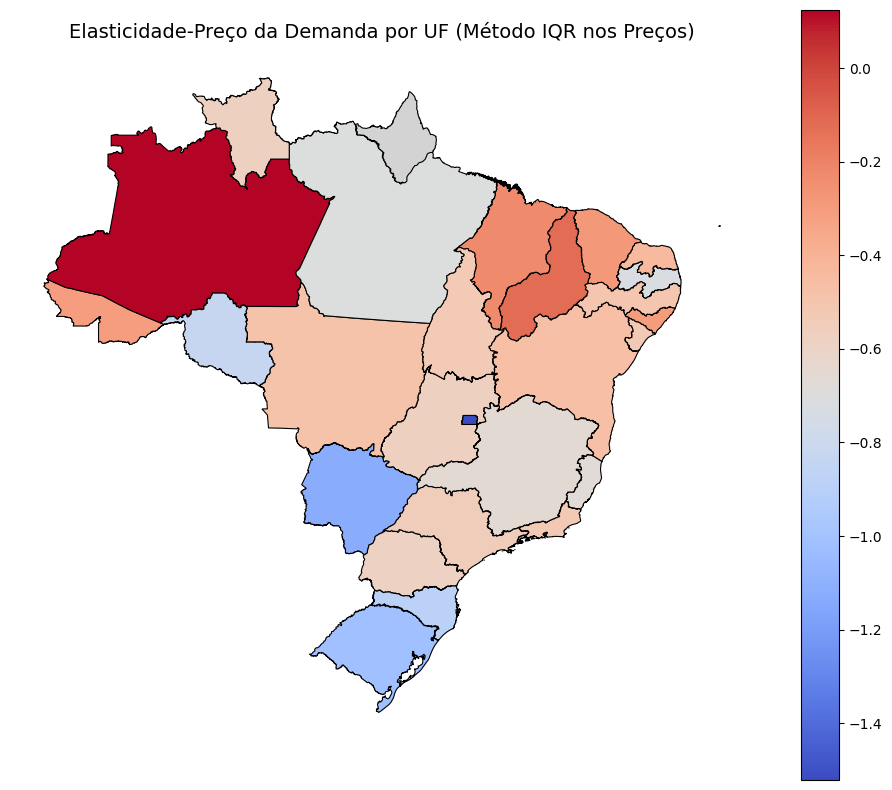

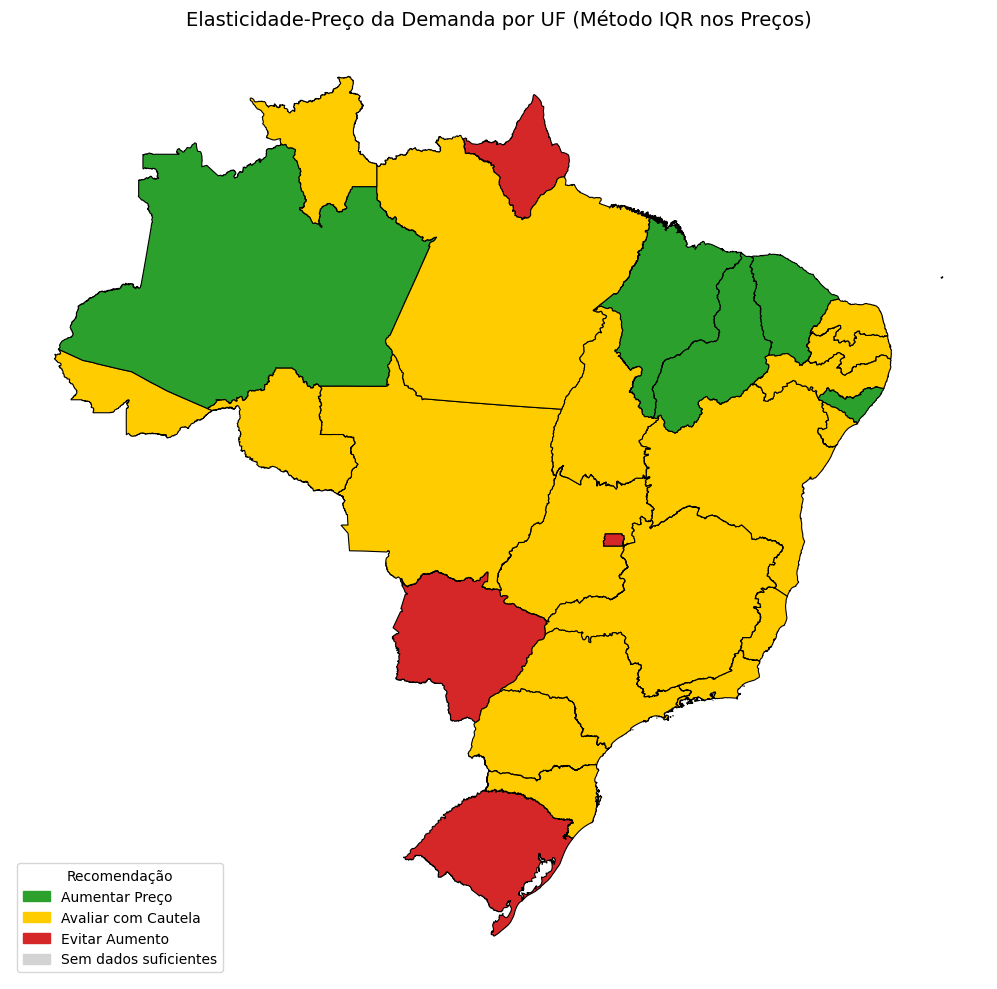

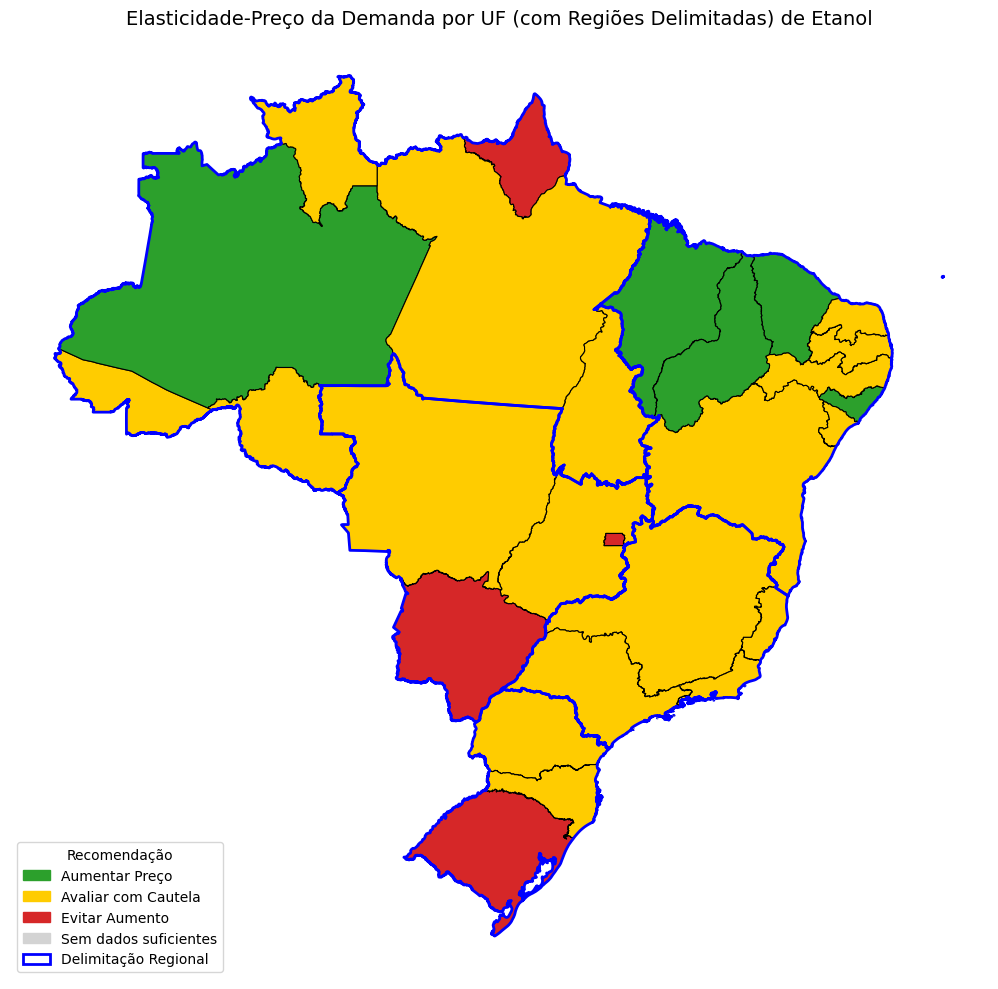

In [19]:
recomendation_by_product("Etanol")

C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\2785338798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['month'])


,sigla_uf,elasticidade_iqr
6,DF,-1.170746
11,MS,-0.895196
25,SP,-0.441248
17,PR,-0.424208
10,MG,-0.412285
14,PB,-0.409968
23,SC,-0.403770
22,RS,-0.374694
18,RJ,-0.289901
8,GO,-0.278905


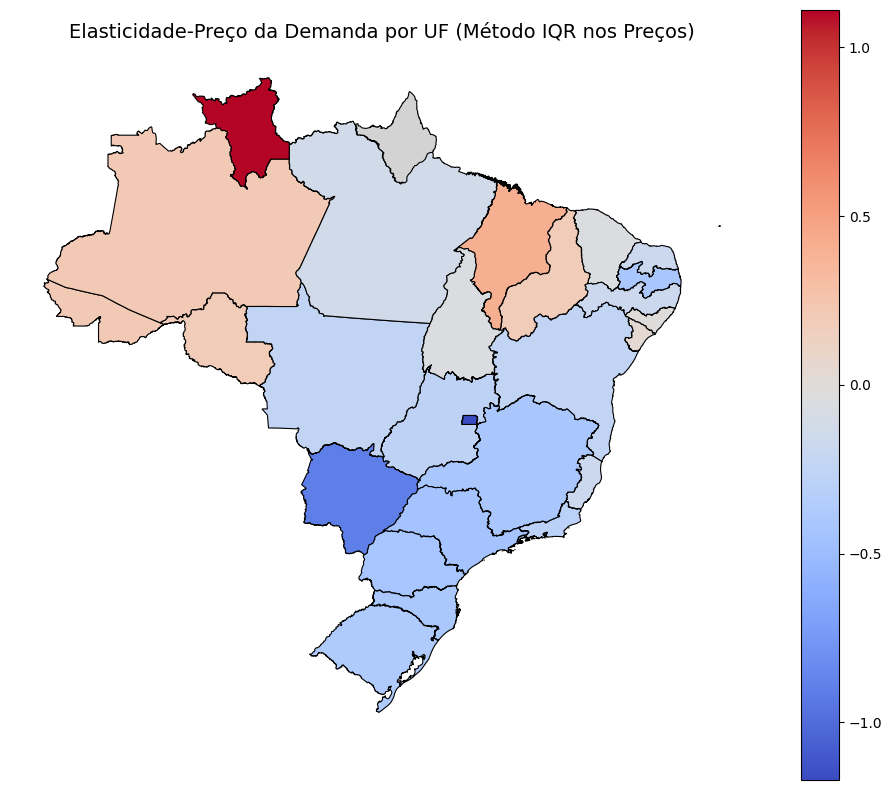

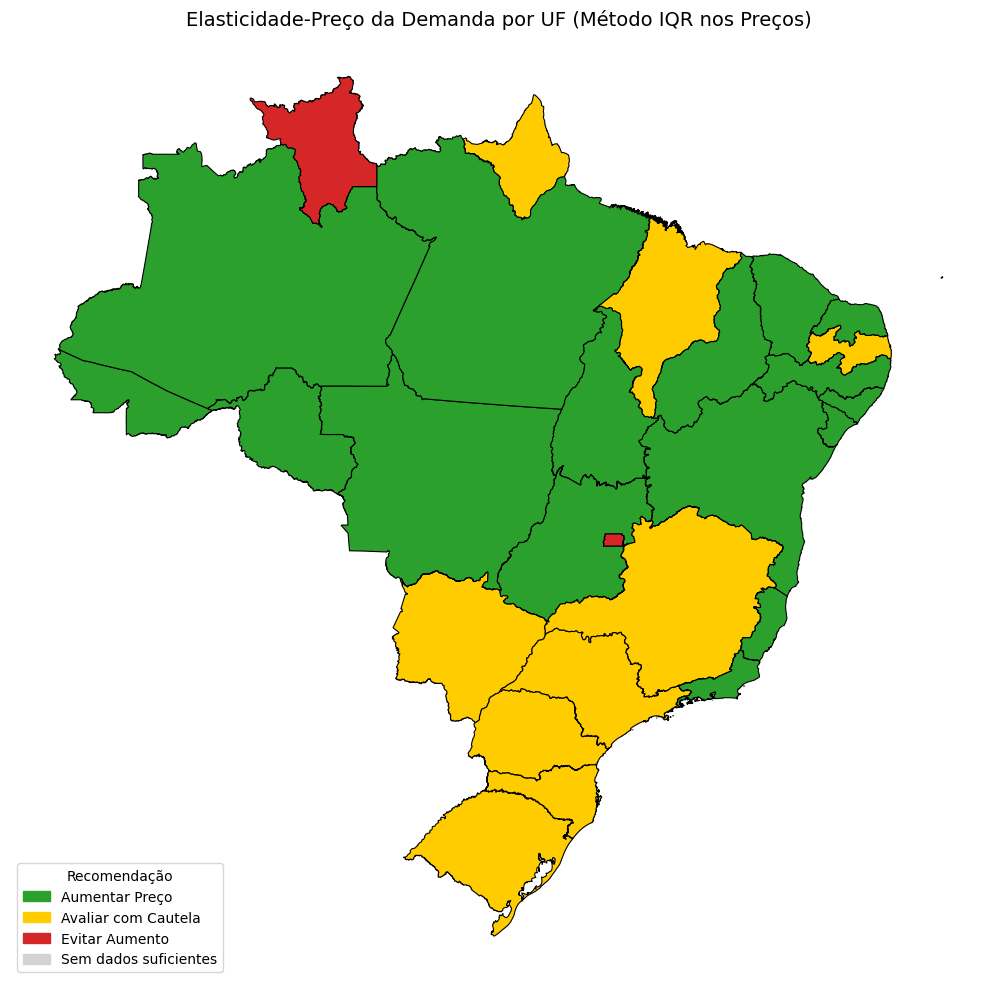

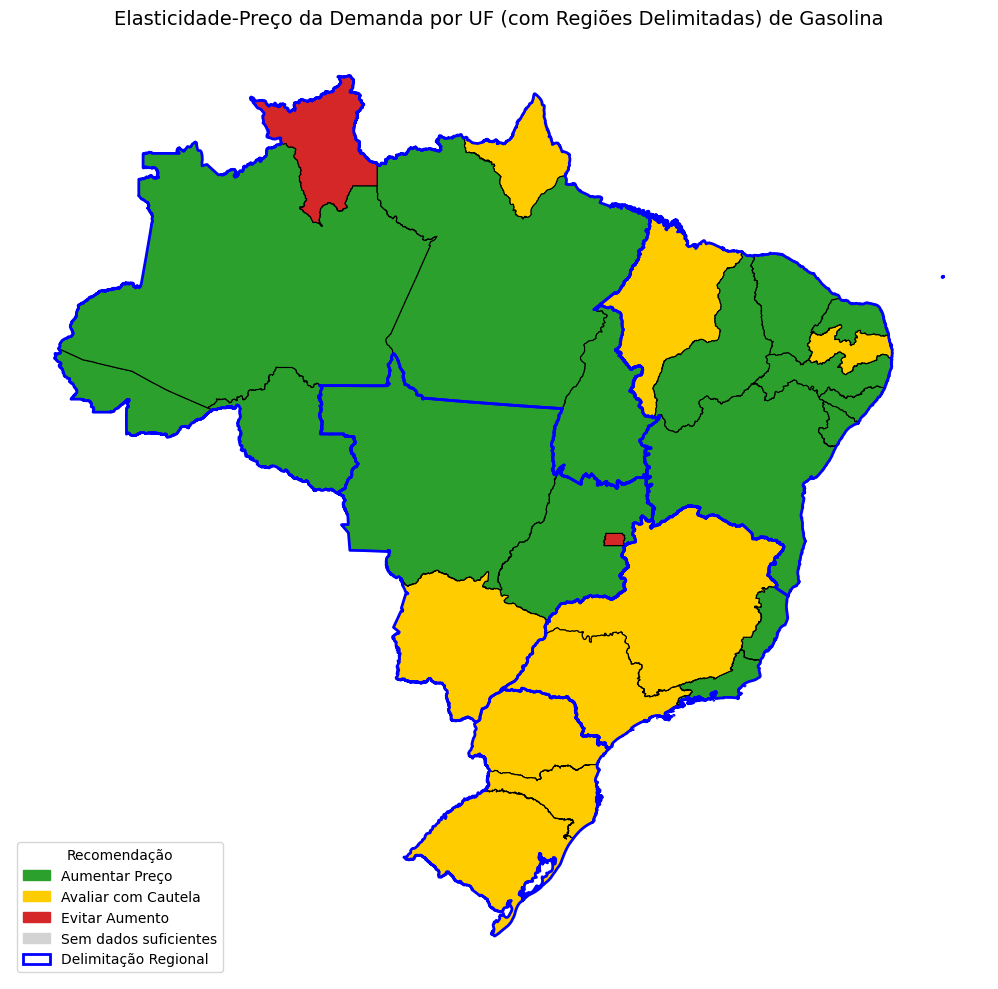

In [20]:
recomendation_by_product("Gasolina")

C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\2785338798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['month'])


,sigla_uf,elasticidade_iqr
6,DF,-1.925678
14,PB,-0.886721
23,SC,-0.882555
15,PE,-0.865240
11,MS,-0.807583
5,CE,-0.795521
25,SP,-0.793370
17,PR,-0.757490
10,MG,-0.610064
18,RJ,-0.590081


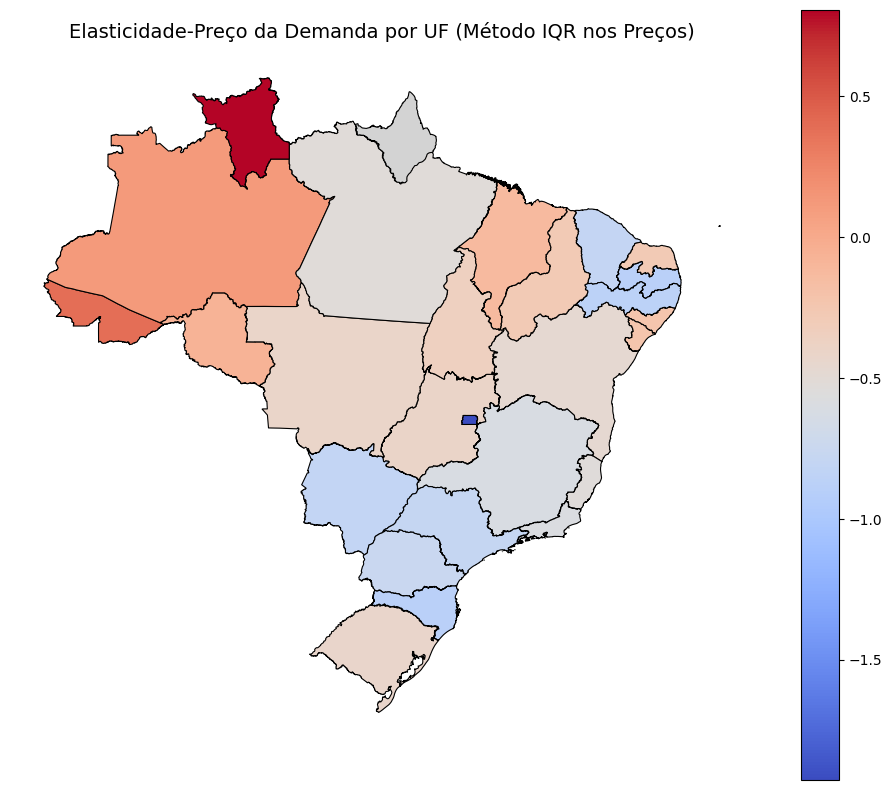

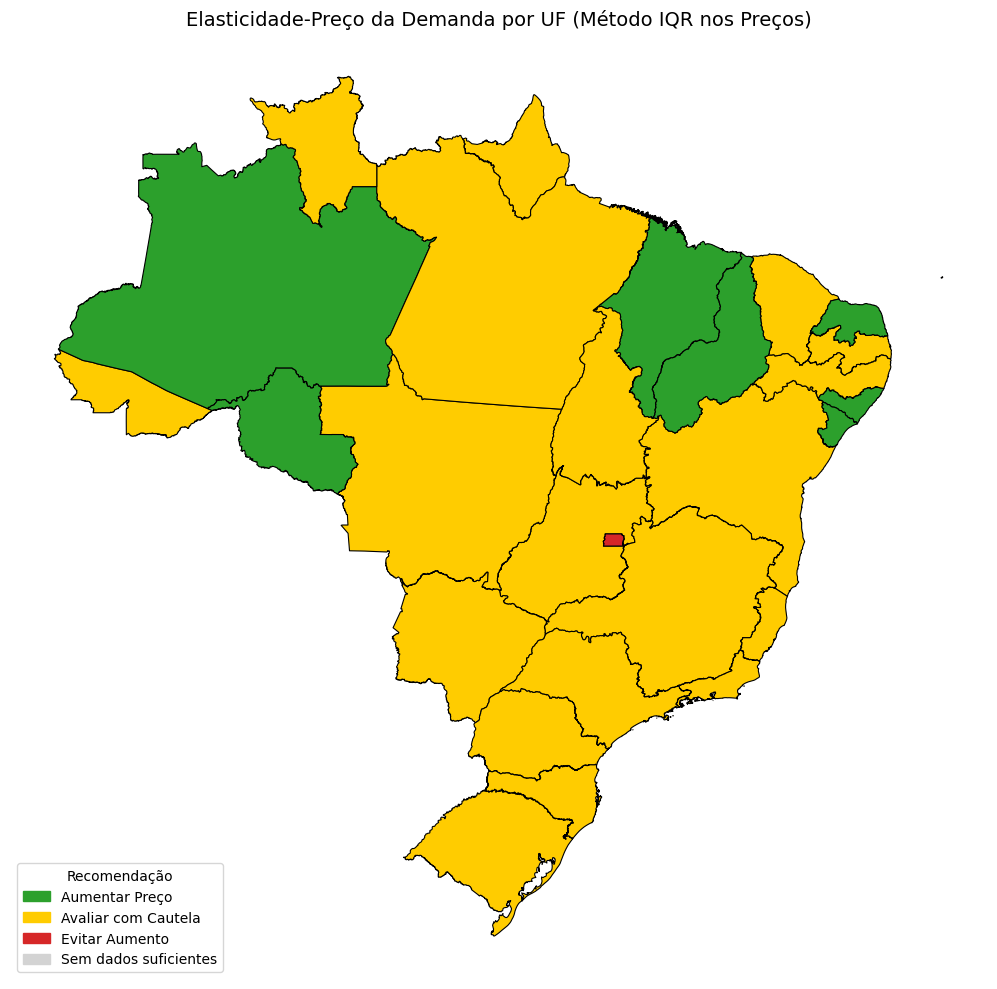

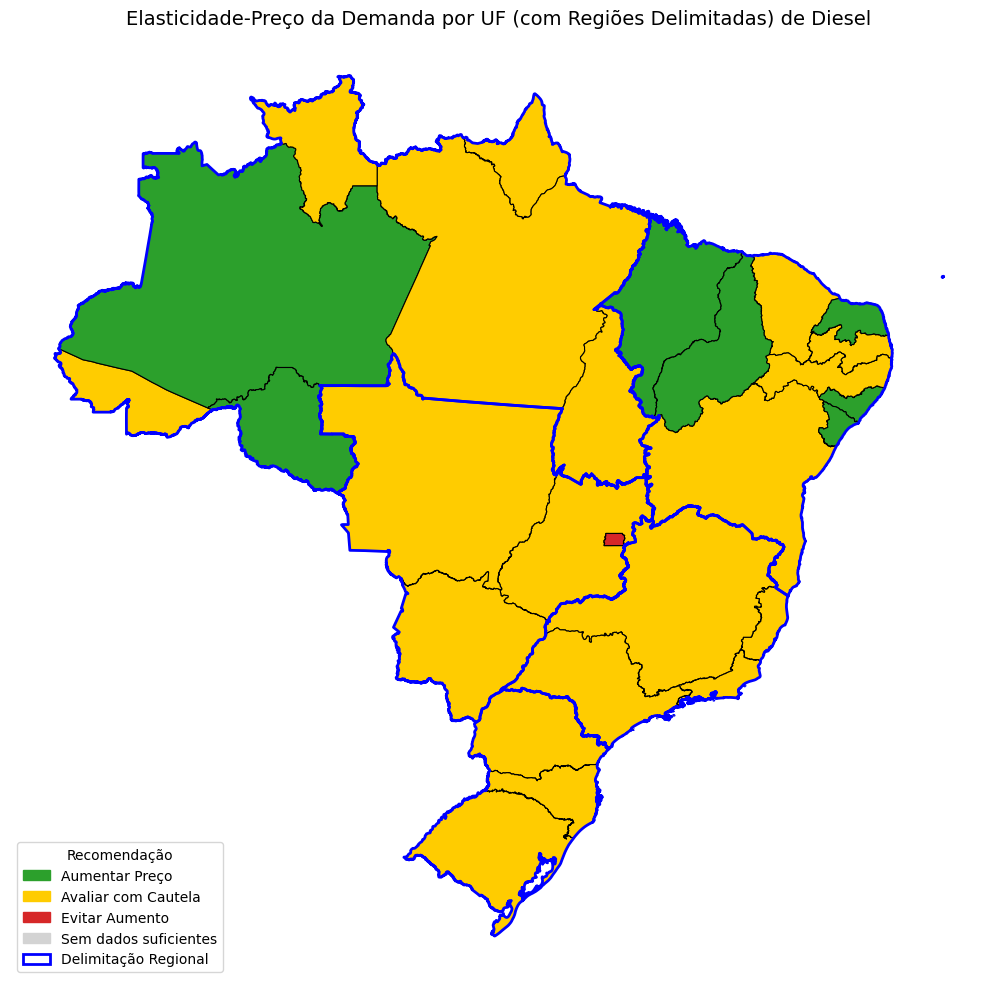

In [21]:
recomendation_by_product("Diesel")

### 1. Operational Recommendations by Product

Create a regionally tailored action plan by product based on the recommendations:

- **High Elasticity**: review margins and competition, consider promotions or loyalty programs.

- **Moderate Elasticity**: simulate gradual pricing scenarios with volume monitoring.

- **Low Elasticity**: recommend controlled price increases to maximize revenue.


In [22]:
# Função de elasticidade
def calc_elast_agg(group):
    if group['avg_preco_compra'].nunique() < 2 or group['volume_vendas'].nunique() < 2:
        return np.nan
    x = np.log(group['avg_preco_compra'])
    y = np.log(group['volume_vendas'])
    return linregress(x, y).slope

# Aplica a função por UF e produto
elasticidade_prod_uf = (
    data.groupby(['sigla_uf', 'produto'])
    .apply(calc_elast_agg)
    .to_frame('elasticidade_iqr')
    .reset_index()
    .dropna()
)

# Classifica a elasticidade
def classificar_faixa(elast):
    if abs(elast) >= 1:
        return 'Alta Elasticidade'
    elif abs(elast) >= 0.3:
        return 'Elasticidade Moderada'
    else:
        return 'Baixa Elasticidade (Inelástico)'

def recomendar_acao(faixa):
    if faixa == 'Alta Elasticidade':
        return 'Evitar aumento – risco de perda de demanda'
    elif faixa == 'Elasticidade Moderada':
        return 'Avaliar aumento com cautela'
    else:
        return 'Considerar aumento de preço'

# Aplica classificação e recomendação
elasticidade_prod_uf['faixa_elasticidade'] = elasticidade_prod_uf['elasticidade_iqr'].apply(classificar_faixa)
elasticidade_prod_uf['recomendacao'] = elasticidade_prod_uf['faixa_elasticidade'].apply(recomendar_acao)

# Cria tabela final
tabela_recomendacoes = (
    elasticidade_prod_uf.pivot(index='sigla_uf', columns='produto', values='recomendacao')
    .reset_index()
)

# Exibe
display(tabela_recomendacoes)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\1227002297.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_elast_agg)


produto,sigla_uf,Diesel,Etanol,Gasolina
0,AC,Considerar aumento de preço,Avaliar aumento com cautela,Considerar aumento de preço
1,AL,Considerar aumento de preço,Avaliar aumento com cautela,Considerar aumento de preço
2,AM,Considerar aumento de preço,Considerar aumento de preço,Considerar aumento de preço
3,AP,Avaliar aumento com cautela,Evitar aumento – risco de perda de demanda,Avaliar aumento com cautela
4,BA,Avaliar aumento com cautela,Avaliar aumento com cautela,Considerar aumento de preço
5,CE,Avaliar aumento com cautela,Avaliar aumento com cautela,Considerar aumento de preço
6,DF,Evitar aumento – risco de perda de demanda,Evitar aumento – risco de perda de demanda,Evitar aumento – risco de perda de demanda
7,ES,Avaliar aumento com cautela,Avaliar aumento com cautela,Considerar aumento de preço
8,GO,Avaliar aumento com cautela,Avaliar aumento com cautela,Considerar aumento de preço
9,MA,Considerar aumento de preço,Considerar aumento de preço,Avaliar aumento com cautela


## Elasticidade por Label

In [23]:
# Cria coluna de ano
data['year'] = pd.to_datetime(data['month']).dt.year

# Aplica filtro de outliers com IQR no avg_preco_compra
Q1 = data['avg_preco_compra'].quantile(0.25)
Q3 = data['avg_preco_compra'].quantile(0.75)
IQR = Q3 - Q1
data_iqr = data[(data['avg_preco_compra'] >= Q1 - 1.5 * IQR) & (data['avg_preco_compra'] <= Q3 + 1.5 * IQR)].copy()

# Estima volume de vendas
fator_litros_por_posto = 100_000
data_iqr['volume_vendas'] = (
    data_iqr['n_estabelecimentos'] * fator_litros_por_posto *
    (1 - data_iqr['monthly_volatility'].fillna(0))
)


In [24]:
# Calcula elasticidade usando regressão log-log por grupo
def calc_elast(grupo):
    if grupo.shape[0] < 5: return np.nan
    x = np.log(grupo['avg_preco_compra'])
    y = np.log(grupo['volume_vendas'])
    if x.nunique() < 2 or y.nunique() < 2:
        return np.nan
    return linregress(x, y).slope

elasticidade_ano_bandeira = (
    data_iqr
    .groupby(['year', 'bandeira_revenda_cat'])
    .apply(calc_elast)
    .reset_index(name='elasticidade')
    .dropna()
)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\3989169609.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_elast)


In [25]:
def faixa_elast(e):
    if abs(e) >= 1:
        return 'Alta Elasticidade'
    elif abs(e) >= 0.3:
        return 'Elasticidade Moderada'
    else:
        return 'Baixa Elasticidade (Inelástico)'

def acao_recomendada(faixa):
    if faixa == 'Alta Elasticidade':
        return 'Evitar aumento'
    elif faixa == 'Elasticidade Moderada':
        return 'Avaliar com cautela'
    else:
        return 'Considerar aumento'

elasticidade_ano_bandeira['faixa_elasticidade'] = elasticidade_ano_bandeira['elasticidade'].apply(faixa_elast)
elasticidade_ano_bandeira['recomendacao'] = elasticidade_ano_bandeira['faixa_elasticidade'].apply(acao_recomendada)


In [26]:
display(elasticidade_ano_bandeira.sort_values(['bandeira_revenda_cat', 'year']))


,year,bandeira_revenda_cat,elasticidade,faixa_elasticidade,recomendacao
0,2004,Blue Label,0.109870,Baixa Elasticidade (Inelástico),Considerar aumento
4,2005,Blue Label,0.105180,Baixa Elasticidade (Inelástico),Considerar aumento
8,2006,Blue Label,0.081703,Baixa Elasticidade (Inelástico),Considerar aumento
12,2007,Blue Label,0.065080,Baixa Elasticidade (Inelástico),Considerar aumento
16,2008,Blue Label,0.109719,Baixa Elasticidade (Inelástico),Considerar aumento
...,...,...,...,...,...
67,2020,White Label,0.422490,Elasticidade Moderada,Avaliar com cautela
71,2021,White Label,0.626919,Elasticidade Moderada,Avaliar com cautela
74,2022,White Label,-0.218178,Baixa Elasticidade (Inelástico),Considerar aumento
77,2023,White Label,0.113241,Baixa Elasticidade (Inelástico),Considerar aumento


In [27]:
elasticidade_ano_bandeira.sort_values(['bandeira_revenda_cat', 'year']).to_clipboard()

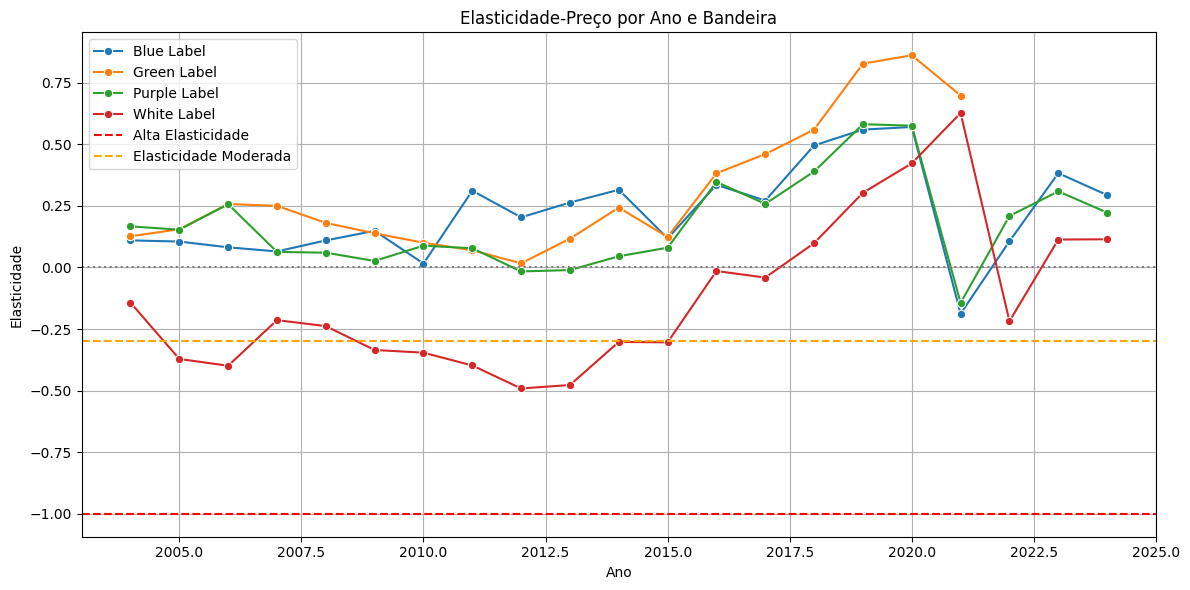

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=elasticidade_ano_bandeira,
    x='year', y='elasticidade',
    hue='bandeira_revenda_cat',
    marker='o'
)
plt.axhline(-1, color='red', linestyle='--', label='Alta Elasticidade')
plt.axhline(-0.3, color='orange', linestyle='--', label='Elasticidade Moderada')
plt.axhline(0, color='gray', linestyle=':')
plt.title("Elasticidade-Preço por Ano e Bandeira")
plt.xlabel("Ano")
plt.ylabel("Elasticidade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Elasticidade por UF e ano
elasticidade_ano_uf = (
    data_iqr
    .groupby(['year', 'sigla_uf'])
    .apply(calc_elast)
    .reset_index(name='elasticidade')
    .dropna()
)

# Classificações
elasticidade_ano_uf['faixa_elasticidade'] = elasticidade_ano_uf['elasticidade'].apply(faixa_elast)
elasticidade_ano_uf['recomendacao'] = elasticidade_ano_uf['faixa_elasticidade'].apply(acao_recomendada)

# Tabela pivô de recomendações
recom_uf_pivot = elasticidade_ano_uf.pivot(index='sigla_uf', columns='year', values='recomendacao')
display(recom_uf_pivot)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\1801590863.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_elast)


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
sigla_uf,,,,,,,,,,,,,,,,,,,,,
AC,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Evitar aumento,...,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Evitar aumento
AL,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela
AM,Considerar aumento,Considerar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Avaliar com cautela,Considerar aumento,Considerar aumento,...,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela
AP,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,...,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento
BA,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,...,Considerar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Considerar aumento,Avaliar com cautela,Avaliar com cautela
CE,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,Avaliar com cautela,...,Avaliar com cautela,Evitar aumento,Evitar aumento,Avaliar com cautela,Evitar aumento,Evitar aumento,Considerar aumento,Evitar aumento,Considerar aumento,Considerar aumento
DF,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,...,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Avaliar com cautela,Evitar aumento,Avaliar com cautela,Evitar aumento,Considerar aumento,Avaliar com cautela
ES,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Avaliar com cautela,Evitar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela
GO,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela


In [30]:
# Elasticidade por região e ano
elasticidade_ano_regiao = (
    data_iqr
    .groupby(['year', 'regiao'])
    .apply(calc_elast)
    .reset_index(name='elasticidade')
    .dropna()
)

# Classificações
elasticidade_ano_regiao['faixa_elasticidade'] = elasticidade_ano_regiao['elasticidade'].apply(faixa_elast)
elasticidade_ano_regiao['recomendacao'] = elasticidade_ano_regiao['faixa_elasticidade'].apply(acao_recomendada)

# Tabela pivô de recomendações
recom_regiao_pivot = elasticidade_ano_regiao.pivot(index='regiao', columns='year', values='recomendacao')
display(recom_regiao_pivot)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\2506680299.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_elast)


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
regiao,,,,,,,,,,,,,,,,,,,,,
Centro-Oeste,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Considerar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela
Nordeste,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento
Norte,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,Considerar aumento,Considerar aumento,Considerar aumento,...,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Evitar aumento
Sudeste,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Avaliar com cautela,Considerar aumento,Considerar aumento
Sul,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,Considerar aumento,...,Considerar aumento,Avaliar com cautela,Considerar aumento,Considerar aumento,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Considerar aumento,Avaliar com cautela,Avaliar com cautela


In [31]:
# Elasticidade por produto e ano
elasticidade_ano_produto = (
    data_iqr
    .groupby(['year', 'produto'])
    .apply(calc_elast)
    .reset_index(name='elasticidade')
    .dropna()
)

# Classificações
elasticidade_ano_produto['faixa_elasticidade'] = elasticidade_ano_produto['elasticidade'].apply(faixa_elast)
elasticidade_ano_produto['recomendacao'] = elasticidade_ano_produto['faixa_elasticidade'].apply(acao_recomendada)

# Tabela pivô de recomendações
recom_produto_pivot = elasticidade_ano_produto.pivot(index='produto', columns='year', values='recomendacao')
display(recom_produto_pivot)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_7204\3580932355.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_elast)


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
produto,,,,,,,,,,,,,,,,,,,,,
Diesel,Considerar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Considerar aumento,...,Avaliar com cautela,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Considerar aumento,Considerar aumento,Avaliar com cautela,Considerar aumento,Avaliar com cautela
Etanol,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento,...,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Avaliar com cautela,Evitar aumento,Avaliar com cautela,Evitar aumento,Avaliar com cautela
Gasolina,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,...,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Evitar aumento,Avaliar com cautela,Avaliar com cautela,Avaliar com cautela,Evitar aumento,Evitar aumento
